# 02477 Exercise 12: Black-box variational inference

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import seaborn as snb
import sys
import os
sys.path.append(os.path.abspath('..'))
from time import time

from jax import grad, value_and_grad
from jax.scipy.stats import norm

from exercise12 import create_linear_regression_data
from exercise12 import AdamOptimizer

# relevant distributions
npdf = lambda x, m, v: jnp.exp(-(x-m)**2/(2*v))/jnp.sqrt(2*jnp.pi*v)
log_npdf = lambda x, m, v: -(x-m)**2/(2*v) - 0.5*jnp.log(2*jnp.pi*v)

# plotting stuff
snb.set_style('darkgrid')
snb.set_theme(font_scale=1.25)
colors = snb.color_palette()

### Overview

The purpose of this exercise is to study and become familiar with **black-box variational inference (BBVI)**, which combines a large proportion of the theory we discussed through the course.



**Content**

- Part 1: Kullback-leibler divergences and mean-field variational families
- Part 2: Black-box variational inference theory
- Part 3: Variational Inference for a linear Gaussian model
- Part 4: Black-box variational inference (BBVI) for the Linear Gaussian model
- Part 5: Spam vs ham detection
- Part 6: Prototyping and testing models using BBVI



**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

**Note**: If you find yourself spending more than 30minutes on a single task, consider asking for help or look up at the solution for inspiration and move forward.


In part 1, we will the combination of mean-field families with the  KL[q||p]  divergence. In part 2, we will review the basic theory of BBVI. To understand the properties of BBVI, we will compare BBVI to classic VI using a linear Gaussian system. Part 3 deals with the classic variational approximation to the linear Gaussian system and part 4 deals with BBVI counterpart. Finally, in part 5+6 we will build a simple text classifier for SPAM detection. We will see how to use BBVI to rapidly comparing and testing different models for binary classification.


---



# Part 1:  Kullback-leibler divergences and mean-field variational families

Before diving into the black-box variational inference algorithm, we will first study the combination of variational inference using $\text{KL}[q||p]$ with mean-field Gaussian families. For the purpose of this analysis, we will assume our target distribution $p$ is a multivariate Gaussian distribution

$$\begin{align*}
p(\mathbf{w}|\mathbf{y}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{V}),
\end{align*}$$

where $\mathbf{w} \in \mathbb{R}^D$ and $\mathbf{m} \in \mathbb{R}^D$ is the mean vector and $\mathbf{V} \in \mathbb{R}^{D \times D}$ covariance matrix. Assuming a mean-field Gaussian family, the variational family $\mathcal{Q}$ is then the collection of distributions of the form

$$\begin{align*}
q(\mathbf{w}) = \prod_{i=1}^D \mathcal{N}(\mathbf{w}|m_i, v_i) = \mathcal{N}(\mathbf{w}|\hat{\mathbf{m}}, \hat{\mathbf{V}}),
\end{align*}$$

where $\hat{\mathbf{V}}$ is a **diagonal matrix** with elements $\hat{\mathbf{V}}_{ii} = v_i > 0$ and $\hat{\mathbf{V}}_{ij} = 0$ for $i \neq j$.



**Task 1.1**: Does the target distribution $p(\mathbf{w}|\mathbf{y})$ belong to the variational family? Why/why not?

**Solution**

The target distribution $p(\mathbf{w}|\mathbf{y})$ does generally **not** belong to the variational family $\mathcal{Q}$, because we have restricted $\mathcal{Q}$ to be the set of Gaussians with diagonal covariance matrix and $\mathbf{V}$ is generally non-diagonal.

**End of solution**


We will now study the optimal approximation $q^*$ in this set-up. More specifically, we are interested in the qualitative behavior of the estimated variances for $q^*$ given by

$$\begin{align*}
q^* = \arg\min_{q\in \mathcal{Q}}\text{KL}[q(\mathbf{w})||p(\mathbf{w}|\mathbf{y})]
\end{align*}$$

where $\text{KL}[q(\mathbf{w})||p(\mathbf{w}|\mathbf{y})]$-divergence, which can be computed analytically for multivariate Gaussians:

$$\begin{align*}
\text{KL}[q||p] = \frac12 \left[\text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right) + \left(\textbf{m}- \hat{\textbf{m}}\right)^T\mathbf{V}^{-1} \left(\textbf{m}- \hat{\textbf{m}}\right) - D  + \log \frac{|\mathbf{V}^{-1}|}{|\hat{\mathbf{V}}|}\right],
\end{align*}$$

where $D > 0$ is the dimension of $\mathbf{w}$.

Inspecting the equation above, we can see that the solution for the variational mean is given by $\hat{\mathbf{m}} = \mathbf{m}$. The focus of this exercise is to study the variances and therefore, we will simplify the problem by assuming $\hat{\textbf{m}} = \textbf{m} = 0$:

$$\begin{align*}
\text{KL}[q(\mathbf{w})||p(\mathbf{w}|\mathbf{y})] = \frac12 \left[\text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right) - D  + \log \frac{|\mathbf{V}^{-1}|}{|\hat{\mathbf{V}}|}\right] \tag{A}.
\end{align*}$$

We don't need this assumption to carry out our analysis, but it is merely to limit the required work for the exercise. Next, we will compute the matrix derivative of eq. (A) with respect to $\hat{\mathbf{V}}$.






To do this, you will need the following results from matrix calculus (see e.g [The Matrix Cookbook](https://www2.imm.dtu.dk/pubdb/edoc/imm3274.pdf) or Section 7.8  in Murphy1)

- For matrix $\mathbf{A}$ and $\mathbf{D}$, where $\mathbf{D}$ is diagonal, we have $\frac{\partial \text{trace}(\mathbf{A}\mathbf{D})}{\partial \mathbf{D}_{ii}} = \mathbf{A}_{ii}$ 


- The derivative of the log determinant of a **diagonal matrix** $\mathbf{D}$ is given by $\frac{\partial \log |\mathbf{D}|}{\partial \mathbf{D}_{ii}} = \frac{1}{\mathbf{D}_{ii}}$ 



**Task 1.2**: Show that the optimal value for $\hat{\mathbf{V}}_{ii}$ in this set-up is given by $\hat{\mathbf{V}}_{ii} = \frac{1}{(\mathbf{V}^{-1})_{ii} }$

*Hints:  Compute the derivative of eq. (A), equate it to zero and solve for $\hat{\mathbf{V}}_{ii}$.*

**Solution**

We have

$$\begin{align*}
\frac{\partial}{\partial \hat{V}_{ii}}\text{KL}[q||p] &= \frac{\partial}{\partial \hat{V}_{ii}}\frac12 \left[\text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right) - D  + \log \frac{|\mathbf{V}^{-1}|}{|\hat{\mathbf{V}}|}\right]\\
%
&= \frac12 \frac{\partial}{\partial \hat{V}_{ii}} \text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right)+ \frac12\frac{\partial}{\partial \hat{V}_{ii}}  \log \frac{|\mathbf{V}^{-1}|}{|\hat{\mathbf{V}}|}\\
%
&= \frac12 \frac{\partial}{\partial \hat{V}_{ii}} \text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right)+ \frac12\frac{\partial}{\partial \hat{V}_{ii}}  \left[ \log |\mathbf{V}^{-1}| - \log |\hat{\mathbf{V}}|\right]\\
%
&= \frac12 \frac{\partial}{\partial \hat{V}_{ii}} \text{trace}\left(\mathbf{V}^{-1}\hat{\mathbf{V}}\right) - \frac12\frac{\partial}{\partial \hat{V}_{ii}}  \log |\hat{\mathbf{V}}|\\
\end{align*}$$

Using the results above yields
$$\begin{align*}
\frac{\partial}{\partial \hat{V}_{ii}}\text{KL}[q||p]&= \frac12 (\mathbf{V}^{-1})_{ii}   -\frac12\frac{1}{\hat{\mathbf{V}_{ii}}}
\end{align*}$$

Equating to zero and solving for $\hat{\mathbf{V}_{ii}}$ yields

$$\begin{align*}
\frac12 (\mathbf{V}^{-1})_{ii}   -\frac12\frac{1}{\hat{\mathbf{V}_{ii}}} = 0 \quad\quad\iff \quad\quad   (\mathbf{V}^{-1})_{ii}   - \frac{1}{\hat{\mathbf{V}_{ii}}} = 0 \quad\quad\iff \quad\quad \hat{\mathbf{V}}_{ii} = \frac{1}{(\mathbf{V}^{-1})_{ii} }
\end{align*}$$




**End of solution**

Next, assume $\mathbf{V} = \begin{bmatrix} 1 & \rho \\ \rho & 1\end{bmatrix}$ for $\rho \in \left(-1, 1\right)$ such that $\rho$ controls the correlation of the target distribution.

**Task 1.3**: Compute and plot  $\mathbf{V}_{11}$ and $\hat{\textbf{V}}_{11}$ as a function of the correlation coefficient $\rho \in \left(-1, 1\right)$. How well does the mean-field approximation capture the correlation of the target distribution? How well does the mean-field approximation capture the marginal variances of the target distribution?

**Solution**


[Text(0.5, 0, 'Correlation coefficient $\\rho$'), Text(0, 0.5, 'Variance')]

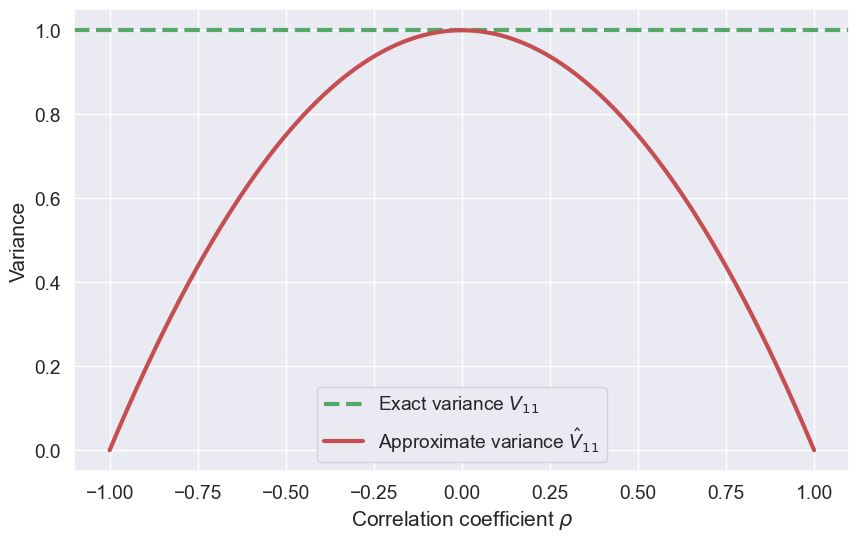

In [6]:
# Create a grid of correlation coefficients rho in the interval (-1, 1)
# Shape: (1000,)
rho_grid = jnp.linspace(-1+1e-6, 1-1e-6, 1000)

# The (1,1) entry of V is always 1 by construction (scalar)
V11 = 1

# Compute the mean-field approximation of the variance, \hat{V}_{11}, for each rho
Vhat_11 = []
for rho in rho_grid:
     # Construct the 2x2 covariance matrix V for the current rho
     # Shape: (2, 2)
     V = jnp.array([[1, rho], [rho, 1]])
     # Compute the inverse of V
     # Shape: (2, 2)
     V_inv = jnp.linalg.inv(V)
     # Compute the mean-field variance for the first variable: 1 / (V_inv[0,0])
     # Scalar, append to list
     Vhat_11.append(1 / V_inv[0, 0])

# Plot the exact and approximate variances as a function of rho
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Plot the true variance (constant line)
ax.axhline(V11, label='Exact variance $V_{11}$', color='g', linestyle='--', linewidth=3)
# Plot the mean-field variances (array of length 1000)
ax.plot(rho_grid, Vhat_11, color='r', label='Approximate variance $\\hat{V}_{11}$', linewidth=3)
ax.legend()
ax.set(xlabel='Correlation coefficient $\\rho$', ylabel='Variance')


Mean-field families cannot capture the correlation structure of the target distribution by construction. And from this experiment, we can easily see that the mean-field approximation underestimates the marginal variances more and more as the correlation of the target distribution becomes stronger.


**End of solution**


---


## Part 2:  Black-box variational inference theory

For the rest of the exercise, we will focus on the **black-box variational inference (BBVI)** algorithm. Recall, the goal of variational inference is to find the best approximation $q \in \mathcal{Q}$ in a given variational family $\mathcal{Q}$ by minimizing the KL divergence $\text{KL}[q||p]$ between the approximation $q$ and the target distribution $p$. In practice, we do this by maximizing the so-called evidence lower bound (ELBO) given by


\begin{align*}
\mathcal{L}\left[q\right] = \mathbb{E}_{q(\mathbf{w})}\left[\log p(\mathbf{y}, \mathbf{w})\right] - \mathbb{E}_{q(\mathbf{w})}\left[\log q(\mathbf{w})\right]\tag{1},
\end{align*}


where $p(\mathbf{y}, \mathbf{w}) = p(\mathbf{y}|\mathbf{w})p(\mathbf{w})$ is the joint distribution of the observations $\mathbf{y}$ and the parameters $\mathbf{w}$.

In this exercise, we will use the set of **mean-field Gaussians** as the variational family, i.e.

\begin{align*}
q(\mathbf{w}) = \prod_{i=1}^D \mathcal{N}(w_i|m_i, v_i) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{V}), \tag{2}
\end{align*}


where $\mathbf{V}$ is a diagonal matrix and $\lambda = \left\lbrace \mathbf{m}, \mathbf{V}\right\rbrace$ are the **variational parameters**. With this choice of variational family, the **entropy term** in eq. (1) can be computed analytically (which you will derive in assignment #3)


\begin{align*}
\mathcal{H}\left[q\right] = -\mathbb{E}_{q(\mathbf{w})}\left[\log q(\mathbf{w})\right] = \frac12\sum_{i=1}^D \log (2\text{e}\pi v_i). \tag{3}
\end{align*}

In classic variational inference, we compute the expectation of the log joint distribution in eq. (1) analytically. However, not all distributions exhibit analytical solutions to these expectations and therefore, this limits the set of distributions we can use. Furthermore, every time we change a component of the model, we have to re-derive these expectations, which makes prototyping many different models a very time-consuming process. 

In BBVI, the expectation of the log joint density is estimated using Monte Carlo sampling. That is,
\begin{align*}
\mathbb{E}_{q(\mathbf{w})}\left[\log p(\mathbf{y}, \mathbf{w})\right] \approx \frac{1}{S}\sum_{s=1}^S \log p(\mathbf{y}, \mathbf{w}^s), \tag{4}
\end{align*}


where $\mathbf{w}^s \sim q(\mathbf{w})$ are samples from the approximate posterior $q$ and $S$ is the number of Monte Carlo samples. Consequently, we can apply VI to a much larger set of models and distributions and we no longer have derive the expected values by hand everytime we want to test a new model. The price we pay for this flexibility is that our objective function and its gradients becomes **stochastic**.

In this exercise, we will focus on the broad class of models, where the observations $\mathbf{y}$ can be assumed **conditionally independent** given $\mathbf{w}$. That is,
\begin{align*}
p(\mathbf{y}, \mathbf{w}) = \prod_{n=1}^N p(y_n|\mathbf{w})p(\mathbf{w}) \tag{5}
\end{align*}

This class of models includes linear regression, logistic regression, multiclass classification, neural networks, Gaussian processes etc. Substituting this decomposition into eq. (4) yields
\begin{align*}
\mathbb{E}_{q(\mathbf{w})}\left[\log p(\mathbf{y}, \mathbf{w})\right] \approx \frac{1}{S}\sum_{s=1}^S \sum_{n=1}^N \log  p(y_n|\mathbf{w}^s) + \frac{1}{S}\sum_{s=1}^S \log p(\mathbf{w}^s) \tag{6}
\end{align*}


For large datasets, this can be prohibitively slow since we need to evaluate $N$ expectations in every single iteration. To alleviate this, we will use **minibatching** and further approximate eq. (6) as follows

$$
\begin{align*}
\mathbb{E}_{q(\mathbf{w})}\left[\log p(\mathbf{y}, \mathbf{w})\right]  \approx \frac{1}{S}\frac{N}{M}\sum_{s=1}^S \sum_{n \in \mathcal{M}} \log  p(y_n|\mathbf{w}^s) + \frac{1}{S}\sum_{s=1}^S \log p(\mathbf{w}^s), \tag{7}
\end{align*}
$$

where $\mathcal{M}$ denotes a random subset of the data with **batch size** $M = |\mathcal{M}|$. Using this approximation, we only have to evaluate $M \ll N$ terms in each iteration and if we resample $\mathcal{M}$ in every iteration, then eq. (7) is an **unbiased** estimator of $\mathbb{E}_{q(\mathbf{w})}\left[\log p(\mathbf{y}, \mathbf{w})\right]$.

In this exercise, we will use the **re-parametrization trick** for estimating the gradients of the form

$$\begin{align*}
\nabla_{\mathbf{\lambda}} \mathbb{E}_{q_{\mathbf{\lambda}}(\mathbf{w})} \! \left[    \log  p(\mathbf{y},\mathbf{w})\right] \approx \frac{1}{S} \sum_{s=1}^S  \nabla_{\mathbf{\lambda}}  \log  p(\mathbf{y}, \mathbf{w}_{\epsilon_s}),
\end{align*}$$
where $\mathbf{w}_{\epsilon_s} = \mathbf{m} + \mathbf{L}\mathbf{\epsilon}_{s}$ and $\mathbf{\epsilon}_{s} \sim q(\mathbf{\epsilon})=\mathcal{N}(\mathbf{\epsilon}|\mathbf{0}, \mathbf{I})$. Because of the mean-field assumption and the diagonal nature of $\mathbf{V}$, we do not need to bother computing the Cholesky decomposition $\mathbf{L}$ for $\mathbf{V}$. Instead, let $\mathbf{s}\in \mathbb{R}^D$ contain the standard deviations of the variational approximation, i.e. $\mathbf{s}_i = \mathbf{v}_i^{\frac12}$, then
$$\begin{align*}
\mathbf{w}_{\epsilon_s} = \mathbf{m} + \mathbf{s} \circ \epsilon_s,
\end{align*}$$
where $\circ$ means element-wise multiplication. Finally, we will use the **Adam** optimizer for optimization.

**Task 2.1**: Explain to your neighbor why we need the re-parametrization trick in the first place, i.e. what is the problem with computing $\nabla_{\mathbf{\lambda}} \mathbb{E}_{q_{\mathbf{\lambda}}(\mathbf{w})} \! \left[    \log  p(\mathbf{y},\mathbf{w})\right]$ directly? [**Discussion question**]

---

The core issue is that our objective  
$$
\mathcal{L}(\lambda)
= \underbrace{\mathbb{E}_{q_\lambda(\mathbf{w})}\left[\log p(\mathbf{y},\mathbf{w})\right]}_{\text{"energy"}}
\;+\;\underbrace{\mathcal{H}\left[q_\lambda(\mathbf{w})\right]}_{\text{entropy}}
$$
depends on $\lambda$ in two ways:

1. **Inside the expectation** $\mathbb{E}_{q_\lambda(w)}[\ln p(y,w)]$, because the sampling distribution $q_\lambda(w)$ itself changes with $\lambda$.  
2. **Analytically** through the entropy term $\mathcal{H}[q_\lambda]$, which for a diagonal Gaussian we can compute in closed form.

---

## Why naïve differentiation fails

If you try to write
$$
\nabla_\lambda\,\mathbb{E}_{q_\lambda(w)}\bigl[\ln p(y,w)\bigr]
\;=\;\nabla_\lambda\int q_\lambda(w)\,\ln p(y,w)\,dw,
$$
you end up with two pieces by the product rule:
$$
\int \underbrace{\nabla_\lambda q_\lambda(w)}_{\text{"score"}}
\;\ln p(y,w)\;dw
\;\;+\;\;
\int q_\lambda(w)\;\nabla_\lambda\bigl[\ln p(y,w)\bigr]\,dw.
$$
But $\ln p(y,w)$ **does not** depend on $\lambda$, so the second term vanishes, leaving
$$
\nabla_\lambda \mathbb{E}_{q_\lambda}[\ln p]
= \int \nabla_\lambda q_\lambda(w)\,\ln p(y,w)\,dw
= \int q_\lambda(w)\,\underbrace{\nabla_\lambda\ln q_\lambda(w)}_{\text{score function}}\;\ln p(y,w)\,dw.
$$
This is the so‐called **score‐function estimator** (a.k.a.\ REINFORCE).  In practice:

- It tends to have **very high variance**, because $\ln p(y,w)$ can be large and unbounded, and the score $\nabla_\lambda\ln q$ can fluctuate wildly.  
- You must subtract baselines, tune control variates, etc., to make it usable—adding complexity.

---

## The re‐parameterization trick to the rescue

Instead, if we can **rewrite** a sample $w\sim q_\lambda$ as a **deterministic** transformation of a $\lambda$‐free noise variable $\epsilon\sim p(\epsilon)$:

$$
w = T(\epsilon;\,\lambda),
$$
then
$$
\mathbb{E}_{q_\lambda(w)}\bigl[\ln p(y,w)\bigr]
= \mathbb{E}_{\epsilon}\bigl[\ln p\bigl(y,\;T(\epsilon;\lambda)\bigr)\bigr],
$$
and we can push the gradient **inside** that expectation:

$$
\nabla_\lambda \mathbb{E}_\epsilon\bigl[\ln p(y,T(\epsilon;\lambda))\bigr]
= \mathbb{E}_\epsilon\bigl[\nabla_\lambda\,\ln p\bigl(y,T(\epsilon;\lambda)\bigr)\bigr].
$$
Now the gradient acts **only** on the inside $\ln p$, not on the sampling distribution.  This:

1. **Greatly reduces variance**, because we're differentiating a smooth function $\ln p(y,T(\epsilon;\lambda))$ rather than noisy score‐function products.  
2. **Automatically** accounts for how $\lambda$ affects samples $w$.  
3. Works whenever you can find such a reparametrization (e.g.\ for Gaussian, Gamma, many other continuous distributions).

---

### In our mean‐field Gaussian case

- We let  
  $$
  w = m \;+\; s \circ \epsilon,
  \quad
  \epsilon\sim\mathcal{N}(0,I)
  $$
  so that $w\sim\mathcal{N}(m,\;\mathrm{diag}(s^2))$.  
- We sample $\epsilon$, compute  
  $\ln p(y,\;m + s\circ\epsilon)$,  
  and differentiate that w.r.t.\ $m$ and $s$.  
- The resulting gradient estimates are **far more stable** than any score‐function approach.

---

### Bottom‐line

The re‐parametrization trick converts
$$
\nabla_\lambda \mathbb{E}_{q_\lambda}[\cdot]
\;\longrightarrow\;
\mathbb{E}_\epsilon\bigl[\nabla_\lambda(\cdot)\bigr],
$$
avoiding high-variance "score‐function" terms and giving us low-variance, efficient stochastic gradients.
_____

## Part 3:  Variational Inference for a linear Gaussian model

To understand the behaviour of BBVI, we will first study the posterior distribution of a linear Gaussian model, because this allows us to:

1) compute the exact posterior (using theory from week 3)
2) compute the variational approximation using analytical ELBO (using theory from week 10 & 11)
3) compute the variational approximation using the BBVI ELBO

and compare the results. 

For a linear Gaussian model with observations $\mathbf{y}$, design matrix $\mathbf{X}$, and parameters $\mathbf{w}$, the joint distribution of the model is given by
\begin{align}
p(\mathbf{y}, \mathbf{w}) = \mathcal{N}(\mathbf{y}|\mathbf{X}\mathbf{w}, \sigma^2 \mathbf{I})\mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I}), \tag{8}.
\end{align}

where the **exact posterior** for $\mathbf{w}$ given $\mathbf{y}$ is given by

\begin{align*}
p(\mathbf{w}|\mathbf{y}) = \mathcal{N}\left(\mathbf{w}|\mathbf{m}, \mathbf{\Sigma}\right),
\end{align*}

where

\begin{align*}
\mathbf{\Sigma}^{-1} &= \frac{1}{\kappa^2} \mathbf{I} + \frac{1}{\sigma^2} \mathbf{X}^T \mathbf{X}\\
\mathbf{m} &= \frac{1}{\sigma^2} \mathbf{\Sigma} \mathbf{X} \mathbf{y}.
\end{align*}

Hence, this will be our gold standard for comparison when using BBVI.




### Calculating the analytical ELBO

 Before setting up the BBVI approximation, we will first derive an analytical **fixed-form** variational approximation for comparison. To do this, we have to calculate the lower bound. We only have to compute the first term in eq. (1) since we already know the entropy term. 



Substituting eq. (8) into the first term in eq. (1) yields
$$\begin{align*}
\mathbb{E}_q\left[\log p(\mathbf{y}, \mathbf{w})\right] &= \mathbb{E}_q\left[\log \prod_{n=1}^N \mathcal{N}(y_n|\mathbf{w}^T\mathbf{x}_n, \sigma^2) \mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I})\right]
%
= \sum_{n=1}^N \mathbb{E}_q\left[\log  \mathcal{N}(y_n|\mathbf{w}^T\mathbf{x}_n, \sigma^2)\right]+
\mathbb{E}_q\left[\log\mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I})\right] \tag{9}
\end{align*}$$

Each term in the sum evaluates to

$$\begin{align*}
\mathbb{E}_q\left[\log  \mathcal{N}(y_n|\mathbf{w}^T\mathbf{x}_n, \sigma^2)\right] &= \mathbb{E}_q\left[- \frac{1}{2} \log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\left(y_n - \mathbf{w}^T \mathbf{x}_n\right)^2\right]
%
=  - \frac{1}{2} \log(2\pi\sigma^2) -\frac{1}{2\sigma^2} \mathbb{E}_q\left[y_n^2 + (\mathbf{w}^T \mathbf{x}_n)^2 - 2y_n \mathbf{w}^T \mathbf{x}_n\right]\tag{10}
\end{align*}$$


We can re-write the quadratic term as follows
$$\begin{align*}
(\mathbf{w}^T \mathbf{x}_n)^2 = \left(\sum_{i=1}^D w_i x_{ni}\right)^2 =  \sum_{i=1}^D \sum_{j=1}^D w_ix_{ni} w_j x_{nj} \tag{11}
\end{align*}$$


Substituting back yields
$$\begin{align*}
\mathbb{E}_q\left[\log  \mathcal{N}(y_n|\mathbf{w}^T\mathbf{x}_n, \sigma^2)\right] &= - \frac{1}{2} \log(2\pi\sigma^2) -\frac{1}{2\sigma^2} y_n^2 - \frac{1}{2\sigma^2} \sum_{i=1}^D \sum_{j=1}^D \mathbb{E}_q\left[w_i w_j\right] x_{ni}  x_{nj} +  \frac{y_n}{\sigma^2} \mathbb{E}_q\left[\mathbf{w}^T\right] \mathbf{x}_n\\
%
 &\stackrel{(a)}{=}- \frac{1}{2} \log(2\pi\sigma^2) -\frac{1}{2\sigma^2} y_n^2 - \frac{1}{2\sigma^2} \sum_{i=1}^D \sum_{j=1}^D m_i m_j x_{ni}  x_{nj}  - \frac{1}{2\sigma^2} \sum_{j=i}^D v_i x^2_{ni} +  \frac{y_n}{\sigma^2} \mathbf{m}^T \mathbf{x}_n\\
 %
 &=- \frac{1}{2} \log(2\pi\sigma^2) -\frac{1}{2\sigma^2} y_n^2 - \frac{1}{2\sigma^2} (\mathbf{m}^T \mathbf{x}_n)^2  - \frac{1}{2\sigma^2} \sum_{j=i}^D v_i x^2_{ni} +  \frac{y_n}{\sigma^2} \mathbf{m}^T \mathbf{x}_n\\
%
&= \log \mathcal{N}(y_n|\mathbf{m}^T \mathbf{x}_n, \sigma^2) - \frac{1}{2\sigma^2}  \sum_{i=1}^D v_i x^2_{ni} \tag{12}, 
\end{align*}$$


where we have used the mean-field assumption in $(a)$, i.e. $\mathbb{E}_q\left[w_i w_j\right] = \mathbb{E}_{q(w_i)}\left[w_i\right]\mathbb{E}_{q(w_j)}\left[ w_j\right] = m_i m_j$ for $i \neq j$ and $\mathbb{E}_q\left[w_i^2\right] = m_i^2 + v_i$ for $i = j$ such that:
$$\begin{align*}
\sum_{i=1}^D \sum_{j=1}^D \mathbb{E}_q\left[w_i w_j\right] x_{ni}  x_{nj} &= \sum_{i=1}^D \sum_{j \neq i} \mathbb{E}_q\left[w_i w_j\right] x_{ni}  x_{nj} + \sum_{i=1}^D \mathbb{E}_q\left[w_i^2\right] x_{ni}^2\\
&= \sum_{i=1}^D \sum_{j \neq i} m_i m_j x_{ni}  x_{nj} + \sum_{i=1}^D \left[m_i^2 + v_i\right] x_{ni}^2 \\
&= \sum_{i=1}^D \sum_{j=1}^D m_i m_j x_{ni}  x_{nj} + \sum_{i=1}^D v_i x_{ni}^2
\end{align*}$$

 Don't hesitate to ask for help if some steps are unclear.


A similar line of calculations yields the expectation for the log prior:
\begin{align*}
\mathbb{E}_q\left[\ln\mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I})\right] &= \sum_{i=1}^D \ln \mathcal{N}(m_i|0, \kappa^2) - \frac{1}{2\kappa^2} \sum_{i=1}^D v_i \tag{13}
\end{align*}


Thus, we can now substitute the results from eq. (3), (12), and (13) to compute the analytical ELBO:
\begin{align}
\mathcal{L}\left[q\right]  = \underbrace{\sum_{n=1}^N \ln \mathcal{N}(y_n|\mathbf{m}^T \mathbf{x}_n, \sigma^2)  -  \frac{1}{2\sigma^2}  \sum_{i=1}^D \sum_{n=1}^N v_i x^2_{ni}}_{\text{expected log likelihood}} + \underbrace{\sum_{i=1}^D \ln \mathcal{N}(m_i|0, \kappa^2) - \frac{1}{2\kappa^2} \sum_{i=1}^D v_i}_{\text{expected log prior}} + \underbrace{\frac12\sum_{i=1}^D \ln (2\text{e}\pi v_i)}_{\text{entropy}} \tag{14}
\end{align}

We can then fit the variational approximation by optimizing the ELBO wrt. the means $m_i$ and variances $v_i$.


**Task 3.1**: Explain how the calculations of the expected log joint above would change if we had used a full rank Gaussian variational family, i.e. $q(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{\Sigma})$, instead of the mean-field family. Note that you do **not** have to do the actual calculations, but just explain which terms would be influenced and how. [**Discussion question**]

*Hints: What does expectations of the form $\mathbb{E}_q\left[w_iw_j\right]$ evaluate to when $q$ is 1) a mean-field Gaussian distribution or 2) a full-rank Gaussian?*

### Implementating a variational approximation based on the analytical ELBO

We will optimize the lower bound in eq. (14) to fit the approximation and we will use the **autograd** library to compute the gradients of $\mathcal{L}\left[q\right]$ wrt. the variational parameters automatically.

The variational parameters are $\mathbf{m}$ and $\mathbf{v}$. Since the variances $v_i > 0$ must be non-negative, we parametrize the variance using $\log v_i$ and collect all variational parameters in a vector $\mathbf{\lambda} = \left\lbrace \mathbf{m}, \log \mathbf{v}\right\rbrace$ and optimize the ELBO wrt. $\mathbf{\lambda}  \in \mathbb{R}^{2D}$ using standard techniques for unconstrained optimization.

In the first part of the exercise, we will consider the hyperparameters fixed and known: $\kappa^2 = 10$ and $\sigma^2=20$.

**Task 3.2**: Below you are given most of the code for computing the variational approximation of the linear Gaussian model. Complete the function `compute_ELBO` for evaluating the ELBO based on eq. (14)

*Hints*
- The function `log_npdf(x, m, v)` computes the log density of a univarate normal distribution with mean m and variance v at point x
- The output of `compute_ELBO` must be a scalar value

In [22]:
class VariationalInference(object):
    """
    Implements mean-field variational inference for a Bayesian linear Gaussian model.

    Attributes
    ----------
    num_params : int
        Number of parameters (D) in the linear model.
    step_size : float
        Step size (learning rate) for the optimizer.
    max_itt : int
        Maximum number of optimization iterations.
    verbose : bool
        If True, prints progress during optimization.
    name : str
        Name of the inference instance.
    X : array-like or None
        Training data features, shape (N, D).
    y : array-like or None
        Training data targets, shape (N,).
    ELBO : float or None
        Evidence Lower Bound value at current parameters.
    num_var_params : int
        Number of variational parameters (2*D: mean and log-variance).
    m : jax.numpy.ndarray
        Mean vector of the variational distribution, shape (D,).
    v : jax.numpy.ndarray
        Variance vector of the variational distribution, shape (D,).
    lam : jax.numpy.ndarray
        Packed variational parameters, shape (2*D,).
    optimizer : AdamOptimizer
        Optimizer instance for updating variational parameters.
    compute_ELBO_and_gradient : function
        Function to compute ELBO and its gradient.
    ELBO_history : list
        History of ELBO values during optimization.
    lam_history : list
        History of variational parameters during optimization.
    m_history : jax.numpy.ndarray
        History of mean vectors during optimization, shape (max_itt, D).
    v_history : jax.numpy.ndarray
        History of variance vectors during optimization, shape (max_itt, D).
    """

    def __init__(self, num_params, step_size=1e-2, max_itt=2000, verbose=False, name='VariationalInference'):
        """
        Initialize the variational inference object.

        Parameters
        ----------
        num_params : int
            Number of parameters (D) in the linear model.
        step_size : float, optional
            Step size for the optimizer (default: 1e-2).
        max_itt : int, optional
            Maximum number of optimization iterations (default: 2000).
        verbose : bool, optional
            If True, prints progress during optimization (default: False).
        name : str, optional
            Name of the inference instance (default: 'VariationalInference').
        """
        self.name = name
        self.verbose = verbose        
        self.X, self.y, self.ELBO = None, None, None

        # Optimization settings
        self.num_params = num_params  # D
        self.step_size = step_size
        self.max_itt = max_itt

        # Number of variational parameters: mean and log-variance for each parameter
        self.num_var_params = 2 * self.num_params  # 2*D

        # Initialize variational parameters for mean-field approximation
        # q(w) = N(w | m, diag(v))
        self.m = jnp.zeros(num_params)  # Mean vector, shape (D,)
        self.v = jnp.ones(num_params) / self.num_params  # Variance vector, shape (D,)
        self.lam = self.pack(self.m, self.v)  # Packed vector, shape (2*D,)

        # Prepare optimizer and gradient function
        self.optimizer = AdamOptimizer(initial_param=self.lam, num_params=self.num_var_params, step_size=self.step_size)
        self.compute_ELBO_and_gradient = value_and_grad(self.compute_ELBO)

    def pack(self, m, v):
        """
        Pack mean and variance into a single vector for unconstrained optimization.

        Equation:
            lam = [m, log(v)]

        Parameters
        ----------
        m : jax.numpy.ndarray, shape (D,)
            Mean vector.
        v : jax.numpy.ndarray, shape (D,)
            Variance vector.

        Returns
        -------
        lam : jax.numpy.ndarray, shape (2*D,)
            Packed vector: first D elements are m, next D are log(v).
        """
        lam = jnp.zeros(self.num_var_params)
        lam = lam.at[:self.num_params].set(m)
        lam = lam.at[self.num_params:2*self.num_params].set(jnp.log(v))
        return lam

    def unpack(self, lam):
        """
        Unpack mean and variance from the packed vector.

        Equation:
            m = lam[:D]
            v = exp(lam[D:2D])

        Parameters
        ----------
        lam : jax.numpy.ndarray, shape (2*D,)
            Packed vector.

        Returns
        -------
        mean : jax.numpy.ndarray, shape (D,)
            Mean vector.
        var : jax.numpy.ndarray, shape (D,)
            Variance vector.
        """
        mean = lam[:self.num_params]
        var = jnp.exp(lam[self.num_params:2*self.num_params])
        return mean, var

    def compute_entropy(self, v=None):
        """
        Compute the entropy of the mean-field Gaussian variational distribution.

        Equation:
            H[q(w)] = 0.5 * sum(log(2*pi*e*v_i))

        Parameters
        ----------
        v : jax.numpy.ndarray, shape (D,), optional
            Variance vector. If None, uses current variational parameters.

        Returns
        -------
        entropy : float
            Entropy value (scalar).
        """
        if v is None:
            v = jnp.exp(self.lam[self.num_params:2*self.num_params])
        # 0.5*log(2*pi*v) + 0.5 for each dimension
        return jnp.sum(0.5 * jnp.log(2 * jnp.pi * v) + 0.5)

    def generate_posterior_samples(self, key, num_samples=1000):
        """
        Generate samples from the variational posterior q(w).

        Equation:
            w ~ N(m, diag(v))

        Parameters
        ----------
        key : jax.random.PRNGKey
            Random key for sampling.
        num_samples : int, optional
            Number of samples to generate (default: 1000).

        Returns
        -------
        samples : jax.numpy.ndarray, shape (num_samples, D)
            Posterior samples.
        """
        return self.m + jnp.sqrt(self.v) * random.normal(key, shape=(num_samples, self.num_params))

    def compute_ELBO(self, lam, key=None):
        """
        Compute the Evidence Lower Bound (ELBO) for the linear Gaussian model.

        Model:
            y | X, w ~ N(Xw, sigma^2 I)
            w ~ N(0, kappa^2 I)
            q(w) = N(m, diag(v))

        ELBO (Eq. 14):
            ELBO = E_q[log p(y | X, w)] + E_q[log p(w)] + H[q(w)]
            where:
                E_q[log p(y | X, w)] = sum_n E_q[log N(y_n | x_n^T w, sigma^2)]
                                     = sum_n -0.5*log(2*pi*sigma^2) - 0.5/sigma^2 * E_q[(y_n - x_n^T w)^2]
                                     = sum_n log N(y_n | x_n^T m, sigma^2) - 0.5/sigma^2 * x_n^T diag(v) x_n
                E_q[log p(w)] = sum_d log N(m_d | 0, kappa^2) - 0.5/kappa^2 * v_d
                H[q(w)] = 0.5 * sum_d log(2*pi*e*v_d)

        Parameters
        ----------
        lam : jax.numpy.ndarray, shape (2*D,)
            Packed variational parameters [m, log(v)].
        key : jax.random.PRNGKey, optional
            Not used in this implementation.

        Returns
        -------
        ELBO : float
            Evidence Lower Bound (scalar).
        """
        # Unpack parameters
        m, v = self.unpack(lam)

        # Model hyperparameters
        sigma2 = 20.0  # Observation noise variance
        kappa2 = 10.0  # Prior variance

        # E_q[log p(y | X, w)]
        # log N(y | X m, sigma^2) - 0.5/sigma^2 * sum_n x_n^T diag(v) x_n
        # log_npdf(y, X@m, sigma2): shape (N,)
        expected_log_lik = jnp.sum(log_npdf(self.y, self.X @ m, sigma2)) \
            - 1/(2 * sigma2) * jnp.sum(self.X ** 2 @ v)

        # E_q[log p(w)]
        # log N(m | 0, kappa^2) - 0.5/kappa^2 * sum_d v_d
        expected_log_prior = jnp.sum(log_npdf(m, 0, kappa2) - 1/(2 * kappa2) * v)

        # Entropy term
        entropy = self.compute_entropy(v)

        # Total ELBO
        return expected_log_lik + expected_log_prior + entropy

    def fit(self, X, y, seed=0):
        """
        Fit the variational approximation q(w) to the data by maximizing the ELBO.

        Parameters
        ----------
        X : array-like, shape (N, D)
            Training data features.
        y : array-like, shape (N,)
            Training data targets.
        seed : int, optional
            Random seed for reproducibility (default: 0).

        Returns
        -------
        self : VariationalInference
            The fitted object. Tracks ELBO and parameter history.
        """
        self.X, self.y, self.N = X, y, len(X)
        self.ELBO_history, self.lam_history = [], []

        # Fix random seed
        key = random.PRNGKey(seed)

        print('Fitting approximation using %s' % self.name)
        t0 = time()
        for itt in range(self.max_itt):
            key, ELBO_key = random.split(key)

            # Evaluate ELBO and its gradient
            self.ELBO, g = self.compute_ELBO_and_gradient(self.lam, key=ELBO_key)

            # Store current values for plotting
            self.ELBO_history.append(self.ELBO)
            self.lam_history.append(self.lam)

            # Take gradient step
            self.lam = self.optimizer.step(g)

            # Verbose output
            if self.verbose:
                if (itt + 1) % 250 == 0:
                    print('\tItt: %5d, ELBO = %3.2f' % (itt, jnp.mean(jnp.array(self.ELBO_history[-250:]))))

        t1 = time()
        print('\tOptimization done in %3.2fs\n' % (t1 - t0))

        # Track quantities through iterations for visualization
        self.ELBO_history = jnp.array(self.ELBO_history)  # (max_itt,)
        self.lam_history = jnp.array(self.lam_history)    # (max_itt, 2*D)
        self.m = self.lam[:self.num_params]               # (D,)
        self.v = jnp.exp(self.lam[self.num_params:2*self.num_params])  # (D,)
        self.m_history = self.lam_history[:, :self.num_params]         # (max_itt, D)
        self.v_history = jnp.exp(self.lam_history[:, self.num_params:2*self.num_params])  # (max_itt, D)

        return self


Let's now generate a synthetic dataset and test the implementation

In [24]:
# dimensions and number of observations
D, N = 2, 500  # D: number of features (int), N: number of data points (int)

# ------------------------------------------------------------------------------
# Generate synthetic data for Bayesian linear regression
# ------------------------------------------------------------------------------
# Function: create_linear_regression_data
# Inputs:
#   D (int): Number of features (dimensions)
#   N (int): Number of data points (observations)
# Outputs:
#   X (jnp.ndarray, shape=(N, D)): Design matrix (features for each data point)
#   y (jnp.ndarray, shape=(N,)):   Target vector (real-valued outputs)
#   w_true (jnp.ndarray, shape=(D,)): True weights used to generate y
#   m_true (jnp.ndarray, shape=(D,)):  Exact posterior mean of weights
#   S_true (jnp.ndarray, shape=(D, D)): Exact posterior covariance of weights
#   exact_marginal (float): Exact log marginal likelihood (evidence)
X, y, w_true, m_true, S_true, exact_marginal = create_linear_regression_data(D, N)

# ------------------------------------------------------------------------------
# Run mean-field variational inference for Bayesian linear regression
# ------------------------------------------------------------------------------
# Class: VariationalInference
# Inputs:
#   num_params (int): Number of model parameters (D)
#   step_size (float): Learning rate for optimizer
#   max_itt (int): Maximum number of optimization iterations
#   verbose (bool): If True, print progress during optimization
# Outputs:
#   vi (VariationalInference): Fitted VI object with learned parameters
vi = VariationalInference(
    num_params=D,      # Number of weights (D)
    step_size=5e-2,    # Learning rate for Adam optimizer
    max_itt=500,       # Number of optimization steps
    verbose=True       # Print progress every 250 iterations
).fit(X, y)

# ------------------------------------------------------------------------------
# Compute relative error between estimated and true posterior mean/variance
# ------------------------------------------------------------------------------
# Function: relative_error
# Inputs:
#   w_est (jnp.ndarray, shape=(D,)): Estimated vector (e.g., VI mean or variance)
#   w_true (jnp.ndarray, shape=(D,)): Ground-truth vector (e.g., true mean or diag of true covariance)
# Output:
#   rel_err (float): Relative squared error (scalar)
def relative_error(w_est, w_true):
    # Equation: rel_err = sum((w_est - w_true)^2) / sum(w_true^2)
    return jnp.sum((w_est - w_true) ** 2) / jnp.sum(w_true ** 2)

# ------------------------------------------------------------------------------
# Print relative errors for mean and marginal variances
# ------------------------------------------------------------------------------
# vi.m: learned posterior mean (shape=(D,))
# m_true: exact posterior mean (shape=(D,))
# vi.v: learned posterior marginal variances (shape=(D,))
# S_true: exact posterior covariance (shape=(D, D)), use jnp.diag(S_true) for marginals
print('Relative error for the posterior mean: %4.3e' % relative_error(vi.m, m_true))
print('Relative error for the marginal posterior variances: %4.3e' % relative_error(vi.v, jnp.diag(S_true)))

# ------------------------------------------------------------------------------
# Sanity check: Assert that the mean error is very small (should be < 1e-6)
# ------------------------------------------------------------------------------
assert (
    relative_error(vi.m, m_true) < 1e-6
), "The relative error of the posterior mean seems too large. Check your implementation of the ELBO"

# ------------------------------------------------------------------------------
# Summary of shapes:
#   X:        (N, D)      - Design matrix (features)
#   y:        (N,)        - Target vector
#   w_true:   (D,)        - True weights
#   m_true:   (D,)        - Exact posterior mean
#   S_true:   (D, D)      - Exact posterior covariance
#   vi.m:     (D,)        - VI estimated mean
#   vi.v:     (D,)        - VI estimated marginal variances
#   exact_marginal: ()    - Scalar log marginal likelihood
# ------------------------------------------------------------------------------

Fitting approximation using VariationalInference
	Itt:   249, ELBO = -1459.62
	Itt:   499, ELBO = -1447.53
	Optimization done in 35.25s

Relative error for the posterior mean: 4.051e-12
Relative error for the marginal posterior variances: 1.058e-10


If the implementation of the ELBO is correct, the relative error of the mean should be close to zero (smaller than $10^{-6}$). But note that the relative error for the variance is somewhat larger. Why?

## Part 4:  Black-box variational inference (BBVI) for the Linear Gaussian model

We are now ready to implement BBVI. One of the major benefits of the BBVI is that we do not need to evaluate the ELBO and its gradient, we only have to implement a function for evaluating the log likelihood and log prior:

In [25]:
# implements isotropic Gaussian prior
def log_prior_pdf(w, prior_var=10):
    """
    Computes the log-density of an isotropic Gaussian prior for each sample of w.

    Mathematical Formulation:
        For each sample w_s (shape: (D,)), the prior is:
            p(w_s) = N(w_s | 0, prior_var * I)
        The log-density for a single sample:
            log p(w_s) = sum_{d=1}^D log N(w_{s,d} | 0, prior_var)
                       = sum_{d=1}^D [ -0.5*log(2*pi*prior_var) - 0.5*w_{s,d}^2/prior_var ]
        For a batch of S samples (shape: (S, D)), returns shape (S,).

    Inputs:
        w         -- jnp.ndarray, shape (S, D)
                     Each row is a sample of the D-dimensional weight vector.
        prior_var -- float (default=10)
                     Prior variance (scalar, same for all dimensions).

    Returns:
        log_prior -- jnp.ndarray, shape (S,)
                     log prior probability for each sample in w.
    """
    # log_npdf(x, m, v) computes log N(x | m, v) elementwise
    # Here: x=w, m=0, v=prior_var, so shape of log_npdf(w, 0, prior_var) is (S, D)
    log_prior = jnp.sum(log_npdf(w, 0, prior_var), axis=1)  # sum over D, result shape (S,)
    return log_prior

# implements the log likelihood for linear regression with Gaussian noise
def log_lik_linreg(X, y, w):
    """
    Computes the log likelihood for a Bayesian linear regression model with Gaussian likelihood.

    Model:
        y_n | x_n, w ~ N(y_n | x_n^T w, sigma2)
        For all n=1,...,N, and for each sample w_s (s=1,...,S).

    Mathematical Formulation:
        For a single sample w_s (shape: (D,)):
            log p(y | X, w_s) = sum_{n=1}^N log N(y_n | x_n^T w_s, sigma2)
        For a batch of S samples (shape: (S, D)):
            For each s=1,...,S:
                f_{n,s} = x_n^T w_s
            log_likelihood[s] = sum_{n=1}^N log N(y_n | f_{n,s}, sigma2)

    Inputs:
        X  -- jnp.ndarray, shape (N, D)
              Design matrix: N data points, each with D features.
        y  -- jnp.ndarray, shape (N,)
              Target vector: N real-valued outputs.
        w  -- jnp.ndarray, shape (S, D)
              S samples of weight vector (each row is a D-dimensional sample).

    Returns:
        log_likelihood -- jnp.ndarray, shape (S,)
                          Log likelihood for each sample in w.

    Details:
        - sigma2 is the known observation noise variance (scalar, fixed to 20).
        - For each sample w_s, compute the predicted mean for all N data points:
              f_{n,s} = x_n^T w_s
          This is done efficiently as X @ w.T, resulting in shape (N, S).
        - For each (n, s), compute log N(y_n | f_{n,s}, sigma2).
        - Sum over n (axis=0) to get total log likelihood for each sample s (result shape (S,)).
    """
    sigma2 = 20  # Observation noise variance (scalar, fixed)

    # Compute predicted means for all data points and all samples:
    # X: (N, D), w.T: (D, S) --> X @ w.T: (N, S)
    # Each column s is the prediction for all N data points using w_s.
    f = X @ w.T  # shape: (N, S)

    # Compute log N(y_n | f_{n,s}, sigma2) for all n, s:
    # y[:, None]: (N, 1), f: (N, S) --> broadcast to (N, S)
    # log_npdf(y[:, None], f, sigma2): (N, S)
    log_probs = log_npdf(y[:, None], f, sigma2)  # shape: (N, S)

    # Sum over all data points (axis=0) to get log likelihood for each sample s:
    log_likelihood = jnp.sum(log_probs, axis=0)  # shape: (S,)

    return log_likelihood

We will re-use most of the code from *VariationalInference* class above and only re-implement the compute_ELBO function

In [ ]:
class BlackBoxVariationalInference(VariationalInference):
    """
    Implements Black-Box Variational Inference (BBVI) for generic models using the reparameterization trick.

    Inherits from:
        VariationalInference -- provides packing/unpacking, entropy, optimizer, etc.

    Attributes
    ----------
    log_prior : callable
        Function to compute log prior probability for samples of w.
        Signature: log_prior(w_samples), shape (S, D) -> (S,)
    log_lik : callable
        Function to compute log likelihood for samples of w.
        Signature: log_lik(X, y, w_samples), X: (N, D), y: (N,), w_samples: (S, D) -> (S,)
    num_samples : int
        Number of Monte Carlo samples S to use for ELBO estimation.
    batch_size : int or None
        If not None, use minibatches of this size for stochastic ELBO estimation.
    seed : int
        Random seed for reproducibility.
    """

    def __init__(self, log_prior, log_lik, num_params, step_size=1e-2, max_itt=2000, num_samples=20, batch_size=None, seed=0, verbose=False):
        """
        Initialize the BBVI object.

        Parameters
        ----------
        log_prior : callable
            Function to compute log prior for w_samples, shape (S, D) -> (S,)
        log_lik : callable
            Function to compute log likelihood, (X, y, w_samples) -> (S,)
        num_params : int
            Number of parameters D in the model.
        step_size : float, optional
            Learning rate for optimizer (default: 1e-2).
        max_itt : int, optional
            Maximum number of optimization iterations (default: 2000).
        num_samples : int, optional
            Number of MC samples S per ELBO estimate (default: 20).
        batch_size : int or None, optional
            Minibatch size for stochastic ELBO (default: None, use full batch).
        seed : int, optional
            Random seed (default: 0).
        verbose : bool, optional
            Print progress (default: False).
        """
        self.log_prior = log_prior
        self.log_lik = log_lik
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.seed = seed
        super(BlackBoxVariationalInference, self).__init__(
            name="Black-box VI",
            num_params=num_params,
            step_size=step_size,
            max_itt=max_itt,
            verbose=verbose
        )

    def compute_ELBO(self, lam, key=None):
        """
        Estimate the Evidence Lower Bound (ELBO) using Monte Carlo samples and the reparameterization trick.

        Mathematical Formulation:
        ------------------------
        The ELBO is:
            ELBO = E_{q(w)}[ log p(y|X,w) ] + E_{q(w)}[ log p(w) ] + H[q(w)]
        where:
            - q(w) = N(w | m, diag(v)), variational posterior
            - H[q(w)] = entropy of mean-field Gaussian (computed analytically)
            - E_{q(w)}[ log p(y|X,w) ] and E_{q(w)}[ log p(w) ] are estimated by MC

        Reparameterization trick:
            For each MC sample s=1..S:
                epsilon_s ~ N(0, I)         # shape: (D,)
                w_s = m + sqrt(v) * epsilon_s   # shape: (D,)
            Stack S samples: w_samples: (S, D)

        Minibatching:
            If self.batch_size is not None:
                - Randomly select a minibatch of indices of size batch_size from {0,...,N-1}
                - Scale the log likelihood term by N / batch_size to keep estimator unbiased

        Parameters
        ----------
        lam : jax.numpy.ndarray, shape (2*D,)
            Packed variational parameters: [m, log(v)]
        key : jax.random.PRNGKey, optional
            JAX random key for reproducibility.

        Returns
        -------
        ELBO : float
            Scalar estimate of the ELBO for current variational parameters.

        Shapes
        ------
        - m: (D,)
        - v: (D,)
        - epsilon: (S, D)
        - w_samples: (S, D)
        - log_prior(w_samples): (S,)
        - log_lik(X, y, w_samples): (S,)
        """
        # Split random key for reproducibility
        key_epsilon, key_minibatch = random.split(key)

        # Unpack variational parameters
        # m: (D,), v: (D,)
        m, v = self.unpack(lam)

        # Generate S samples from epsilon ~ N(0, I), shape: (S, D)
        epsilon = random.normal(key_epsilon, shape=(self.num_samples, self.num_params))

        # Reparameterization: w_samples = m + sqrt(v) * epsilon, shape: (S, D)
        w_samples = m + jnp.sqrt(v) * epsilon

        # Compute expected log prior term:
        # log_prior(w_samples): (S,) -> mean over S samples -> scalar
        expected_log_prior_term = jnp.mean(self.log_prior(w_samples))

        # Compute expected log likelihood term:
        if self.batch_size:
            # Minibatch mode
            # Randomly sample batch_size indices from 0..N-1 without replacement
            batch_idx = random.choice(
                key_minibatch,
                jnp.arange(self.N),
                shape=(self.batch_size,),
                replace=False
            )
            # Select minibatch: X_batch: (batch_size, D), y_batch: (batch_size,)
            X_batch = self.X[batch_idx, :]
            y_batch = self.y[batch_idx]
            # log_lik(X_batch, y_batch, w_samples): (S,)
            # Scale by N / batch_size for unbiased estimator
            expected_log_lik_term = (self.N / self.batch_size) * jnp.mean(
                self.log_lik(X_batch, y_batch, w_samples)
            )
        else:
            # Full batch mode
            # log_lik(self.X, self.y, w_samples): (S,)
            expected_log_lik_term = jnp.mean(self.log_lik(self.X, self.y, w_samples))

        # Compute entropy of q(w): analytic for mean-field Gaussian
        # self.compute_entropy(v): scalar
        entropy_term = self.compute_entropy(v)

        # Total ELBO: scalar
        ELBO = expected_log_lik_term + expected_log_prior_term + entropy_term

        return ELBO


**Task 4.1**: Complete the implementation of the function *compute_ELBO* above.

*hints*: 

- *The *re-parametrization trick* states that we can replace $w_i \sim \mathcal{N}(w_i|m_i, v_i)$ with $w_i = m_i + v_i^{\frac12} \epsilon_i$ for $\epsilon_i \sim \mathcal{N}(0, 1)$*.

- *Start by implementing ELBO without mini-batching, test it, and once it works, come back and implement mini-batching*.


Note that the implementation of the class *VariationalInference* was hard-coded for the linear Gaussian model, whereas the class *BlackBoxVariationalInference* can easily be adapted to other models by providing the relevant log prior and log likelihood functions.

Let's test it and compare with the algorithm from Part 1.

Fitting approximation using VariationalInference
	Optimization done in 5.57s

Fitting approximation using Black-box VI
	Optimization done in 7.01s

------------------------------------------------------------
VI
------------------------------------------------------------
Relative error for the posterior mean: 5.015e-09
Relative error for the posterior variances: 5.238e-04


------------------------------------------------------------
BBVI
------------------------------------------------------------
Relative error for the posterior mean: 7.431e-06
Relative error for the posterior variances: 3.652e-02


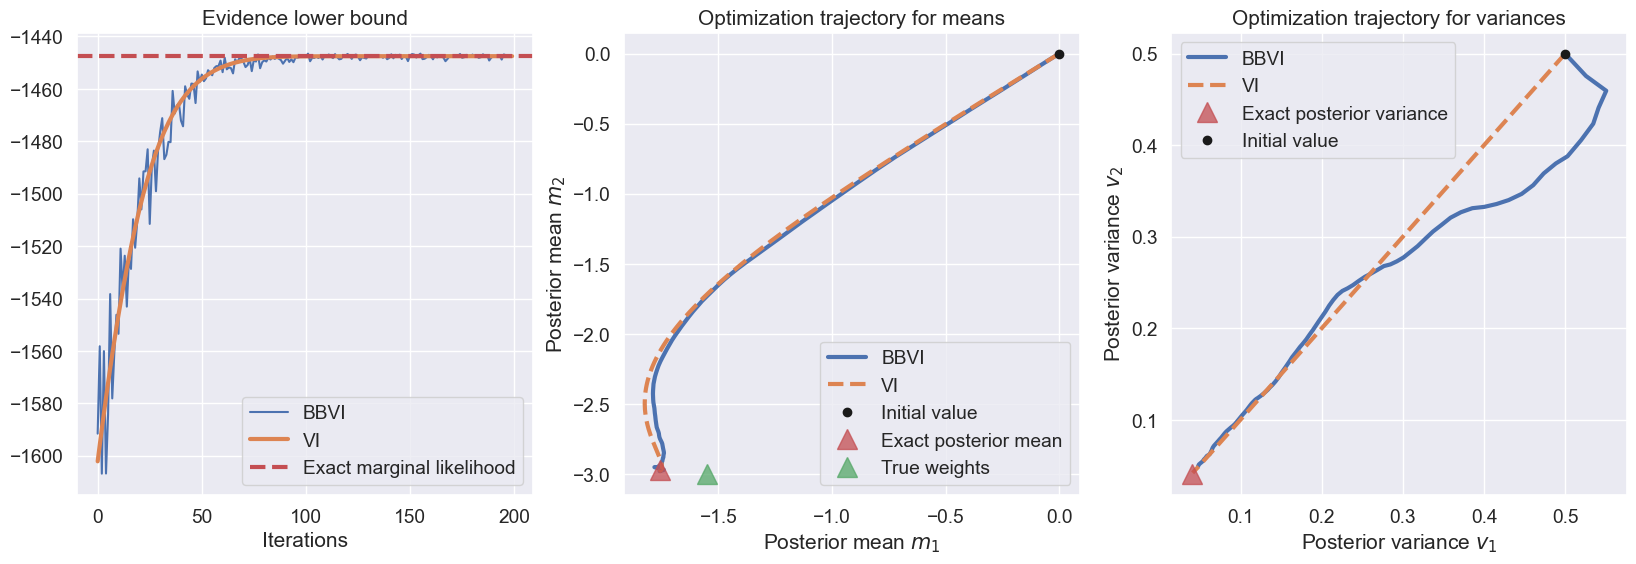

In [ ]:
# settings for BBVI and VI comparison on Bayesian linear regression for BBVI and VI comparison on Bayesian linear regression
num_params = X.shape[1]  # Number of model parameters (D), shape: ()  # Number of model parameters (D), shape: ()
max_itt = 200            # Maximum number of optimization iterations, shape: ()            # Maximum number of optimization iterations, shape: ()
step_size = 5e-2         # Learning rate for optimizer, shape: ()
num_samples = 7          # Number of Monte Carlo samples per BBVI step, shape: ()
batch_size = None

# fit approximations
vi = VariationalInference(num_params, step_size, max_itt).fit(X, y)
bbvi = BlackBoxVariationalInference(log_prior_pdf, log_lik_linreg, num_params, step_size, max_itt, num_samples, batch_size).fit(X, y)

# plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].plot(bbvi.ELBO_history, color=colors[0], label='BBVI')
axes[0].plot(vi.ELBO_history, linewidth=3, color=colors[1], label='VI')
axes[0].axhline(exact_marginal, color='r', linestyle='--', label='Exact marginal likelihood', linewidth=3)
axes[0].set(title='Evidence lower bound', xlabel='Iterations')
axes[0].legend()

axes[1].plot(bbvi.m_history[:, 0], bbvi.m_history[:, 1], '-', color=colors[0], label='BBVI', linewidth=3)
axes[1].plot(vi.m_history[:, 0], vi.m_history[:, 1], '--', color=colors[1], label='VI', linewidth=3)
axes[1].plot(vi.m_history[0, 0], vi.m_history[0, 1], 'ko', label='Initial value')

axes[1].plot(m_true[0], m_true[1], 'r^', label='Exact posterior mean', markersize=15, alpha=0.75)
axes[1].plot(w_true[0], w_true[1], 'g^', label='True weights', markersize=15, alpha=0.75)
axes[1].set(xlabel='Posterior mean $m_1$', ylabel='Posterior mean $m_2$', title='Optimization trajectory for means')

axes[2].plot(bbvi.v_history[:, 0], bbvi.v_history[:, 1], '-', color=colors[0], label='BBVI', linewidth=3)
axes[2].plot(vi.v_history[:, 0], vi.v_history[:, 1], '--', color=colors[1], label='VI', linewidth=3)
axes[2].plot(S_true[0,0], S_true[1,1], 'r^', label='Exact posterior variance', markersize=15, alpha=0.75)
axes[2].plot(vi.v_history[0, 0], vi.v_history[0, 1], 'ko', label='Initial value')
axes[2].set(xlabel='Posterior variance $v_1$', ylabel='Posterior variance $v_2$', title='Optimization trajectory for variances')

for i in range(3):
    axes.flat[i].legend()

print(60*'-')
print('VI')
print(60*'-')
print('Relative error for the posterior mean: %4.3e' % relative_error(vi.m, m_true))
print('Relative error for the posterior variances: %4.3e' % relative_error(vi.v, jnp.diag(S_true)))
print('\n')

print(60*'-')
print('BBVI')
print(60*'-')
print('Relative error for the posterior mean: %4.3e' % relative_error(bbvi.m, m_true))
print('Relative error for the posterior variances: %4.3e' % relative_error(bbvi.v, jnp.diag(S_true)))


**Task 4.2**: Explain the difference between the true weights, the exact posterior mean, and the approximate posterior mean. [**Discussion question**]

In that final figure you see three different “means” plotted in the 2-D weight space:

1. **True weights (green triangle)**  
   $$
     w_{\text{true}}
   $$
   are the ground-truth parameters that *generated* the data.  They’re what you’d recover exactly only if you had infinite data and used a perfectly flexible model.

2. **Exact posterior mean (red triangle)**  
   $$
     m_{\text{exact}}
     = \mathbb{E}_{p(w\mid X,y)}[\,w\,]
   $$
   is the Bayesian posterior’s center of mass given your prior and your finite dataset $(X,y)$.  
   - It **shrinks** $w_{\text{true}}$ toward the prior mean (often zero), with strength governed by the prior precision and the data’s information.  
   - In our linear regression example, if the prior is $\mathcal{N}(0,\sigma_0^2 I)$ and you observe noisy data, the posterior mean is a compromise between the OLS estimate and zero.

3. **Approximate posterior mean (VI or BBVI path endpoints)**  
   $$
     m_{\text{VI}}
     \approx \mathbb{E}_{q(w)}[\,w\,]
   $$
   is the mean vector learned by your variational algorithm.  It tries to match the true posterior mean but is restricted by:
   - The **mean-field Gaussian** family (it cannot represent any posterior correlations).  
   - The **stochastic optimization** (in BBVI) or closed-form CAVI updates (in VI).

---

### Why they differ

- **True vs. exact posterior**:  
  Even the full Bayesian posterior “pulls” the true weights toward the prior if data are noisy or scarce.  So $m_{\text{exact}}$ sits between $w_{\text{true}}$ and the prior mean (zero).

- **Exact posterior vs. VI approximation**:  
  - **Mean-field restriction** forces the variational posterior to be axis-aligned and factorized; it cannot capture any covariance in the true posterior, so the optimal $m_{\text{VI}}$ will generally be slightly shifted relative to $m_{\text{exact}}$.  
  - **Stochastic noise** in BBVI adds additional small deviations even from the CAVI path (you see the wiggly blue trajectory vs. the straight‐line orange path).

In the printed **relative errors**, you see that:

- VI (dashed orange) almost exactly hits the red triangle, giving a near-zero relative error in the mean.  
- BBVI (solid blue) converges close, but with a bit more error, because of Monte Carlo noise and step‐size choices.

---

#### Take‐home

- **Green** = “what generated the data.”  
- **Red**  = “what the true Bayesian posterior believes after seeing finite data and a prior.”  
- **Orange/Blue** = “what your approximation spits out.”  

Variational inference trades off *exactness* (red) for *tractability* (closed-form updates) or *flexibility* (black-box sampling), and you can see those trade-offs in how closely the orange/blue dots land on the red triangle.  



**Task 4.3**: Experiment with different numbers of MC samples by changing the *num_samples* parameter, e.g. try *num_samples*$ = 1, 10, 100$ etc. for BBVI. What happens? [**Discussion question**]

When you change the number of Monte Carlo samples $S$ per BBVI gradient step, you directly trade off **bias** (really, variance) vs. **compute-cost**:

---

## 1. Very few samples (e.g. $S=1$)  
- **Extremely noisy gradients.**  Each stochastic gradient estimate is dominated by the single draw $w^{(1)}\sim q$.  
- **ELBO trajectory** (left panel) will “zig-zag” wildly from iteration to iteration.  
- **Convergence** may stall or even diverge unless you use very small step-sizes or add extra variance reduction (control variates, larger batches).  
- **Final fit** will often be poor: the estimated mean/variance will jitter around a biased solution, and relative error stays high.

---

## 2. Moderate samples (e.g. $S=10$)  
- **Variance is lower**, but still noticeable.  
- **ELBO** is smoother, though you’ll still see some residual ripple.  
- **Convergence** is more reliable, and the final parameters are closer to the true posterior.  
- **Compute per iteration** is 10× higher than $S=1$, so you may need fewer iterations but more time per step.

---

## 3. Many samples (e.g. $S=100$)  
- **Very low‐variance gradients.**  Each update almost looks “deterministic.”  
- **ELBO** curve overlaps almost exactly with the closed‐form VI curve (at least in early iterations).  
- **Converged solution** is essentially the same as classic VI (up to the mean-field assumption).  
- **Compute cost** per iteration is high; you may need fewer iterations, but overall runtime can increase.

---

## 4. Practical take-aways

- **Bias–variance trade-off**:  
  - **Low $S$** → cheap but noisy → need more iterations (and smaller step-sizes) → overall can be slow and unstable.  
  - **High $S$** → expensive per step but smooth → large step-sizes possible → converges in fewer steps → might still be slower overall if $S$ is too large.

- **Sweet spot** often lies in the range $S=5$–$20$ (depending on your model and dimensionality), especially if you combine with **minibatching** and **control variates**.

- **Adaptive strategies** exist: start with a small $S$ to “roughly” find the neighborhood, then increase $S$ late in optimization to polish the solution.

---

### Quick numerical illustration (schematic)

| $S$      | ELBO noise  | Iterations to converge | Wall-clock time per iter | Final parameter error |
|-----------:|-------------|------------------------|--------------------------|------------------------|
| **1**      | very high   | >2000 (often stalls)   | low                      | high                   |
| **10**     | moderate    | ~500                   | moderate                 | low                    |
| **100**    | very low    | ~200                   | high                     | very low               |

By tuning $S$, you control the variance of your stochastic gradients—and thus the stability and efficiency of BBVI.  


**Task 4.4**: Fix the number of samples to *num_samples*$ = 20$ and experiment with *batch_size*$ = \text{None}, 1, 10, 100$. What happens? Increase the number of iterations if needed. [**Discussion question**]

When you switch from full-data updates to minibatching in BBVI, you trade off **gradient variance** against **per-step cost**.  Here’s what typically happens as you vary `batch_size` with a fixed $$S=20$$ samples per step:

---

## 1. `batch_size=None` (full-batch)

- **Gradient variance:** Nearly zero.  You’re summing over all $N$ data points in each MC estimate, so the only noise is from the $S=20$ draws of $\epsilon$.  
- **ELBO trajectory:** Very smooth and monotonic (aside from small Monte-Carlo jitter).  
- **Convergence:** Fast in iterations (often 100–200 iters) and stable.  
- **Per-step cost:** Highest, since you evaluate the entire dataset each update.  

---

## 2. `batch_size=100` (large minibatches)

- **Gradient variance:** Low–moderate.  Each update sees about 10% of the data, so you still average out a lot of noise.  
- **ELBO:** Relatively smooth, minor ripples.  Converges in ~200–300 iters.  
- **Cost per iter:** ~10× cheaper than full batch.  Overall wall-clock time often a bit lower than full-batch, depending on vectorization.  

---

## 3. `batch_size=10` (medium minibatches)

- **Gradient variance:** Noticeable.  One update sees only ~1% of the data, so the stochastic gradient oscillates more.  
- **ELBO:** You’ll see a “sawtooth” pattern: it rises on average but with spikes and dips each iter.  
- **Convergence:** Takes more iterations (~500–1000) to settle, but each iter is cheap.  
- **Cost trade-off:** Might be the **sweet spot** if your data are large: cheap steps and acceptable convergence speed.  

---

## 4. `batch_size=1` (extreme stochastic)

- **Gradient variance:** Very high!  Each update uses a single datum (plus the MC noise), so the ELBO curve is extremely noisy.  
- **ELBO:** Jumps around, may even decrease for many steps before climbing.  
- **Convergence:** Slows dramatically—often thousands of iterations.  You may need to reduce the learning rate or add variance reduction.  
- **When to use:** Rarely optimal by itself, but if you have **streaming data** or an online setting, batch-size 1 is the only option.  

---

### Overall pattern

| batch_size | per-step cost | gradient variance | iters to converge | wall-clock time |
|:----------:|:-------------:|:-----------------:|:-----------------:|:---------------:|
| None       | very high     | very low          | 100–200           | high            |
| 100        | high          | low               | 200–300           | medium–high     |
| 10         | medium        | medium            | 500–1000          | medium          |
| 1          | low           | very high         | >2000             | medium–high     |

- **Larger batches** → smoother gradients → fewer iterations but more work per iteration.  
- **Smaller batches** → noisier gradients → more iterations but cheap per iteration.  

---

### Practical advice

- For moderate $N$ (thousands–tens of thousands), **full-batch** or **large minibatches** (≥100) often win.  
- For very large $N$ (millions), medium minibatches (10–100) are a good trade-off.  
- Always **reschedule** the minibatch each iteration to keep the estimator unbiased.  
- If convergence is too slow with tiny batches, you can **increase** `num_samples` or **lower** the step size.  


# Part 5:  Spam vs ham detection

In this part, we will build a simple spam vs ham (not spam) classifier based on a dataset of SMS messages. We'll see how BBVI can be extremely useful when prototyping different models.

First, we will load the dataset:

In [12]:
# load data
data = jnp.load('./sms_data.npz')
train_texts = data['train_texts']
test_texts = data['test_texts']
y_train = data['train_targets']
y_test = data['test_targets']
labels = data['labels']

# find spam and ham examples
spam_idx = jnp.where(y_train == 1)[0]
ham_idx = jnp.where(y_test == 0)[0]

# print a few examples
key = random.PRNGKey(1)
key1, key2 = random.split(key)

print('Spam:')
for n in random.choice(key1, spam_idx, shape=(10,), replace=False):
    print(train_texts[n])
print('')
print('Ham:')
for n in random.choice(key2, ham_idx, shape=(10,), replace=False):
    print(train_texts[n])

Spam:
thesmszone.com lets you send free anonymous and masked messages..im sending this message from there..do you see the potential for abuse???
you've won tkts to the euro2004 cup final or £800 cash, to collect call 09058099801 b4190604, pobox 7876150ppm
hot live fantasies call now 08707500020 just 20p per min ntt ltd, po box 1327 croydon cr9 5wb 0870 is a national rate call
i don't know u and u don't know me. send chat to 86688 now and let's find each other! only 150p/msg rcvd. hg/suite342/2lands/row/w1j6hl ldn. 18 years or over.
urgent! your mobile no 077xxx won a £2,000 bonus caller prize on 02/06/03! this is the 2nd attempt to reach you! call 09066362206 asap! box97n7qp, 150ppm
loans for any purpose even if you have bad credit! tenants welcome. call noworriesloans.com on 08717111821
sms services. for your inclusive text credits, pls goto www.comuk.net login= 3qxj9 unsubscribe with stop, no extra charge. help 08702840625.comuk. 220-cm2 9ae
wamma get laid?want real doggin locations 

Again, we will rely on *transfer learning* to predict the label of each text. First, we have used a pretrained FastText model to compute 300-dimensional embedding for each text. Afterwards, we have reduced the dimensionality to $D = 15$ (to speed up the computations). The FastText method is not part of the curriculum of this course, but if you are curiuos, you can read more about it here: [https://fasttext.cc/docs/en/crawl-vectors.html](https://fasttext.cc/docs/en/crawl-vectors.html).

As a result, we have a $D = 15$ vector representing each text. Let's inspect the first two components visually:

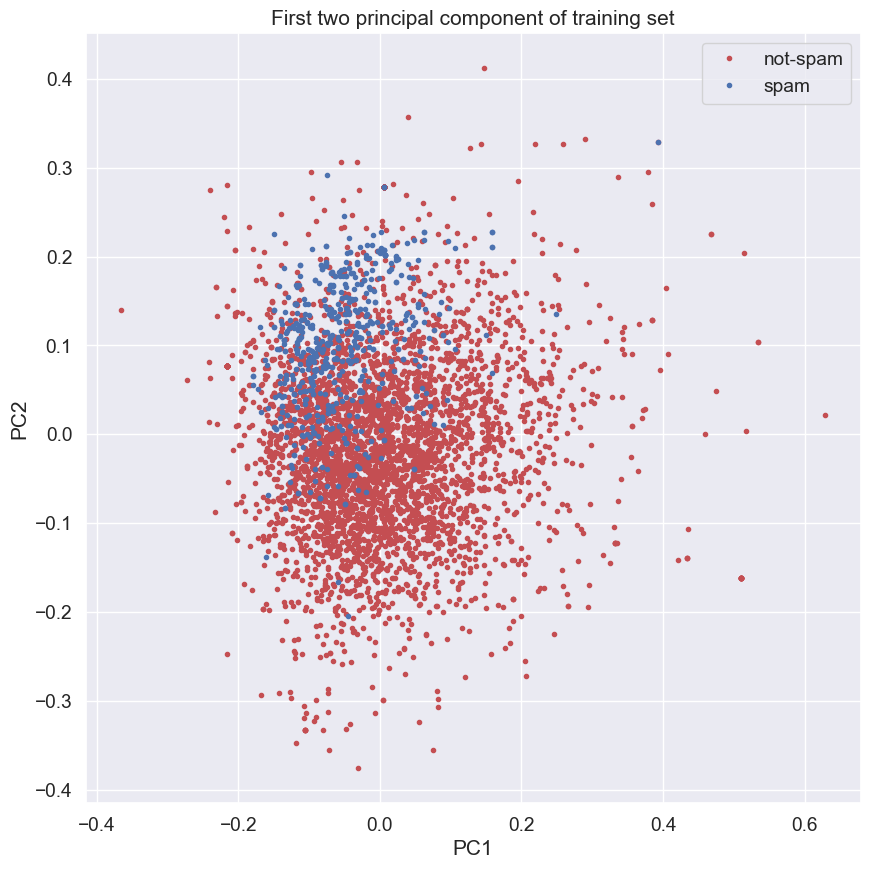

In [13]:
x_train = data['ztrain'] # embeddings for training set
x_test = data['ztest']   # embeddings for test set

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(x_train[y_train == 0, 0], x_train[y_train==0, 1], 'r.', label=labels[0])
ax.plot(x_train[y_train == 1, 0], x_train[y_train==1, 1], 'b.', label=labels[1])
ax.set(xlabel='PC1', ylabel='PC2', title='First two principal component of training set')
ax.legend();

Let's now consider the model
\begin{align*}
    p(\mathbf{y}, \mathbf{w}) = \prod_{n=1}^N p(y_n|\mathbf{x}_n, \mathbf{w})p(\mathbf{w})=  \prod_{n=1}^N p(y_n|\mathbf{x}_n, \mathbf{w})\mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1} \mathbf{I})\tag{15}
\end{align*}

where $y_n \in \left\lbrace 0, 1 \right\rbrace$ is the label of the $n$-th text, $\mathbf{x}_n \in \mathbb{R}^{D}$ is the PCA features representation of each text, $p(y_n|\mathbf{x}_n, \mathbf{w})$ is the likeliood for the $n$-th observation and $p(\mathbf{w})$ is a Gaussian prior on the weights. 

We will explore and compare three different likelihoods for binary classification:

**Likelihood 1**: Standard Bernoulli distribution with a logistic sigmoid as inverse link function

\begin{align*}
    p(y_n|\mathbf{w}, \mathbf{x}_n) = \text{Ber}\left(y_n|\sigma(\mathbf{w}^T\mathbf{x}_n)\right) \tag{16}
\end{align*}

**Likelihood 2**: Standard Bernoulli distribution with a Probit function $\mathbf{\Phi}$ (CDF of standarized normal distribution) as inverse link function

\begin{align*}
    p(y_n|\mathbf{w}, \mathbf{x}_n) = \text{Ber}\left(y_n|\Phi(\mathbf{w}^T\mathbf{x}_n)\right) \tag{16}
\end{align*}

**Likelihood 3**: Robust likelihood with noisy labels

The third likelihood we consider is a so-called *robust likelihood* that assumes a fraction of the training labels are mislabelled (e.g. samples that are actually spam are labelled as non-spam and vice versa), which can make the model more robust to outliers etc.

Here we assume that a given training example, i.e. $y_i$, is mislabelled with probability $\epsilon \in \left\lbrace 0, 1\right\rbrace$. Let $e_i \in \left\lbrace 0,1 \right\rbrace$ be $1$ if $y_i$ is mislabelled and otherwise $e_i = 0$. 

\begin{align*}
    p(y_i|\mathbf{w}, \mathbf{x}_i, e_i) &=    \text{Ber}\left(y_i|(1-e_i)\sigma(\mathbf{w}^T\mathbf{x}_i) + e_i\sigma(-\mathbf{w}^T\mathbf{x}_i)\right)\\
    p(e_i) &= \text{Ber}(e_i|\epsilon) 
\end{align*}

Finally, we can use the sum rule to marginalize out $e_i$:

\begin{align*}
p(y_i|\mathbf{w}, \mathbf{x}_i) &= \sum_{e_i} p(y_i|\mathbf{w}, \mathbf{x}_i, e_i) p(e_i)\\
%
&= (1-\epsilon)\text{Ber}\left(y_i|\sigma(\mathbf{w}^T\mathbf{x}_i)\right) + \epsilon \text{Ber}\left(y_i|\sigma(-\mathbf{w}^T\mathbf{x}_i)\right)
\end{align*}

Hence, this likelihood has an additional parameters $\epsilon \in \left[0, 1\right]$


We will now let $f = \mathbf{w}^T \mathbf{z}$ and plot likelihoods and log likelihoods for observing $y = 1$ for each the three likelihoods for $f \in \left[-10, 10\right]$. Use $\epsilon = 0.05$ for the robust model:

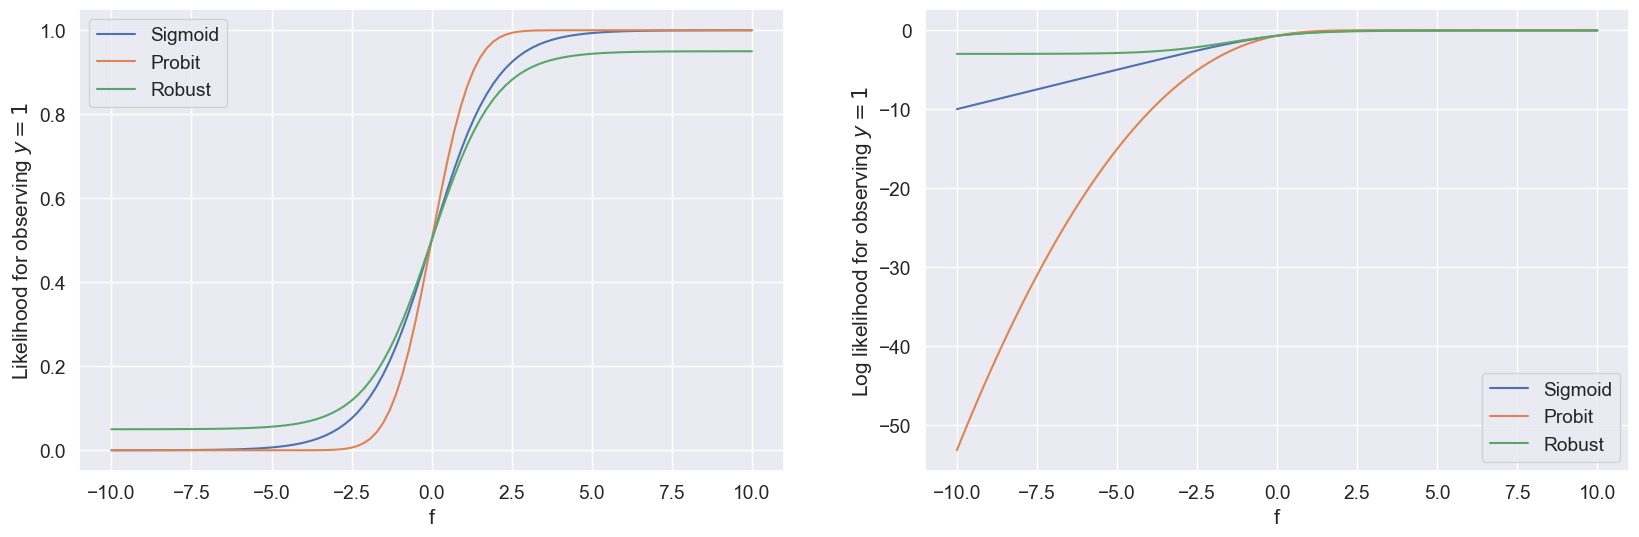

In [14]:
# likelihoods
phi = lambda f: norm.cdf(f)
sigmoid = lambda f: 1/(1+jnp.exp(-f))
robust_sigmoid = lambda f, epsilon: (1-epsilon)*sigmoid(f) + epsilon*sigmoid(-f) 

# array for f
f = jnp.linspace(-10, 10, 100)

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(f, sigmoid(f), label='Sigmoid')
ax[0].plot(f, phi(f), label='Probit')
ax[0].plot(f, robust_sigmoid(f, 0.05), label='Robust')
ax[0].legend()
ax[0].set(ylabel='Likelihood for observing $y=1$', xlabel='f')

ax[1].plot(f, jnp.log(sigmoid(f)), label='Sigmoid')
ax[1].plot(f, jnp.log(phi(f)), label='Probit')
ax[1].plot(f, jnp.log(robust_sigmoid(f, 0.05)), label='Robust')
ax[1].legend()
ax[1].set(ylabel='Log likelihood for observing $y=1$', xlabel='f');

**Task 5.1**: Study the plots and comment on to which degree each of the three likelihoods penalize outliers. [**Discussion question**]


When you look at those two panels (likelihood on the left, log‐likelihood on the right) for $y=1$ as a function of the “score” $f=w^T x$, here’s how each behaves in the **outlier** regime ($f\ll0$):

---

## 1. Standard logistic (“Sigmoid”)  
$$
p(y=1\mid f)=\sigma(f), 
\quad
\ln p(y=1\mid f)=\ln\sigma(f).
$$
- **Tail behavior**:  
  $$
  \sigma(f)\approx e^{\,f}\quad(f\to -\infty),
  $$
  so  
  $$
  \ln\sigma(f)\approx f\quad\bigl(\to -\infty\bigr).
  $$
- **Penalty** grows **linearly** in $\lvert f\rvert$.  Very large negative $f$ incur arbitrarily large negative log‐likelihood (strong penalty).

---

## 2. Probit  
$$
p(y=1\mid f)=\Phi(f),
\quad
\ln p(y=1\mid f)=\ln\Phi(f).
$$
- **Tail behavior**:  
  For $f\to -\infty$,
  $$
  \Phi(f)\;\approx\;\frac1{\lvert f\rvert\sqrt{2\pi}}\,e^{-f^2/2},
  $$
  so  
  $$
  \ln\Phi(f)\;\approx\;-\frac{f^2}{2} - \tfrac12\ln(2\pi) - \ln\lvert f\rvert.
  $$
- **Penalty** grows **quadratically** in $\lvert f\rvert$ (plus smaller log terms).  Even harsher than the linear logistic penalty for large outliers.

---

## 3. Robust logistic (flip‐noise $\epsilon$)  
$$
p(y=1\mid f)
=(1-\epsilon)\,\sigma(f)\;+\;\epsilon\,\sigma(-f),
\quad \epsilon=0.05.
$$
- **Tail behavior**:  
  As $f\to -\infty$, $\sigma(f)\to0$ but $\sigma(-f)\to1$.  Thus
  $$
  p(y=1\mid f)\;\approx\;\epsilon\,.
  $$
  Consequently
  $$
  \ln p(y=1\mid f)\;\approx\;\ln\epsilon
  \quad\bigl(\text{finite!}\bigr).
  $$
- **Penalty** is **capped** at $-\ln\epsilon$.  Outliers beyond a certain point cannot drive the loss any lower.

---

### Intuition summary

| Likelihood   | Tail penalty on $\ln p(y=1\mid f)$     | Outlier behaviour               |
|:------------:|:----------------------------------------:|:-------------------------------:|
| **Logistic** | $\approx f$  (linear in $\lvert f\rvert$) | Unbounded penalty               |
| **Probit**   | $\approx -f^2/2$ (quadratic)            | Even stronger penalty           |
| **Robust**   | $\to \ln\epsilon$  (finite floor)       | Bounded penalty → ignores extreme outliers |

Thus, **probit** is the most punishing of extreme mis‐predictions, **logistic** is moderately punishing, and the **robust** version effectively “gives up” on points with huge negative $f$, assigning them a constant (finite) worst‐case penalty of $\ln\epsilon$.  


# Part 6:  Prototyping and testing models using BBVI

The goal of this part is to implement all three models. We will start with the "standard" Bayesian logistic regression model with a Gaussian prior:

In [15]:
from jax.scipy.special import logsumexp

log_bernoulli_logit = lambda x, z: (1-x)*jnp.log(1-sigmoid(z)) + x*jnp.log(sigmoid(z))

def log_lik1(X, y, w):
    """
    Implements the log likelihood function for the logistic regression model with the sigmoid as inverse link function.
    S is number of MC samples, N is number of datapoints in likelihood and D is the dimensionality of the model

    Inputs:
    X              -- Design matrix (np.array of size N x D)
    y              -- vector of target (np.array of size N)
    w              -- Matrix of weights (np.array of size S x D)

    outputs:
    log_likelihood -- Array of log likelihood for each sample in w (np.array of size S)
     """

    # compute linear part (dim: S x N)
    f = w @ X.T

    # compute logits (dim: S x N)
    logits = log_bernoulli_logit(y, f)

    # sum across data points (dim: S)
    log_likelihood = jnp.sum(logits, axis=1)   

    return log_likelihood

def predictive_model1(z, w_samples):
    return jnp.mean(sigmoid(w_samples@z.T), axis=0)

# settings
num_params = 15
max_itt = 2000
step_size = 5e-2
num_samples = 20
batch_size = 200

# set prior 
log_prior = lambda w: log_prior_pdf(w, 100.)

# fit approximations
bbvi1 = BlackBoxVariationalInference(log_prior, log_lik1, num_params, step_size, max_itt, num_samples, batch_size, verbose=True)
bbvi1.fit(x_train, y_train);


Fitting approximation using Black-box VI
	Itt:   249, ELBO = -2800.14
	Itt:   499, ELBO = -2731.90
	Itt:   749, ELBO = -2717.87
	Itt:   999, ELBO = -2730.70
	Itt:  1249, ELBO = -2713.99
	Itt:  1499, ELBO = -2723.34
	Itt:  1749, ELBO = -2702.01
	Itt:  1999, ELBO = -2719.91
	Optimization done in 95.81s



And let's compute the accuracy and $F_1$-score ([$F_1$ scores on wiki](https://en.wikipedia.org/wiki/F-score)):

In [16]:
def compute_accuracy(prob, y):
    # predict
    yhat = 1.0 * (prob > 0.5)
    # compute accuracy
    return jnp.mean(yhat.ravel() == y.ravel())

def compute_f1(prob, y):
    # predict
    yhat = 1.0 * (prob > 0.5)
    # evaluate precision/recall for f1
    tp = jnp.logical_and(yhat == 1, y == 1).sum()
    fp = jnp.logical_and(yhat == 1, y == 0).sum()
    fn = jnp.logical_and(yhat == 0, y == 1).sum()
    precision, recall = tp/(tp+fp), tp/(tp+fn)
    # compute f1
    return 2* (precision*recall)/(precision+recall)

key = random.PRNGKey(123)
w1_samples = bbvi1.generate_posterior_samples(key)
p1_test = predictive_model1(x_test, w1_samples)

print(f'M1: Test  accuracy = {compute_accuracy(p1_test, y_test):3.2f}, Test  F1 = {compute_f1(p1_test, y_test):3.2f}')

M1: Test  accuracy = 0.72, Test  F1 = 0.50


**Task 6.1**: Implement the probit regression model. Fit the model using BBVI and compute the test metrics

*Hints*:
- remember to both implement the log joint and the function for the evaluating predictive distribution

**Solution**

In [17]:
log_phi = lambda f: norm.logcdf(f)
log_bernoulli_probit = lambda x, z: (1-x)*jnp.log(1-phi(z)) + x*log_phi(z)

def log_lik2(X, y, w):

    # compute linear part (dim: S x N)
    f = w @ X.T

    # compute log probits (dim: S x N)
    log_probits = log_bernoulli_probit(y, f)
    log_likelihood = jnp.sum(log_probits, axis=1)   # (dim: S)

    return log_likelihood

def predictive_model2(z, w_samples):
    return jnp.mean(phi(w_samples@z.T), axis=0)

bbvi2 = BlackBoxVariationalInference(log_prior_pdf, log_lik2, num_params, step_size, max_itt, num_samples, batch_size,  verbose=True)
bbvi2.fit(x_train, y_train);



Fitting approximation using Black-box VI
	Itt:   249, ELBO = -2773.14
	Itt:   499, ELBO = -2738.00
	Itt:   749, ELBO = -2725.10
	Itt:   999, ELBO = -2736.64
	Itt:  1249, ELBO = -2721.35
	Itt:  1499, ELBO = -2730.15
	Itt:  1749, ELBO = -2710.82
	Itt:  1999, ELBO = -2726.80
	Optimization done in 124.19s



In [18]:
key = random.PRNGKey(1234)
w2_samples = bbvi2.generate_posterior_samples(key)
p2_test = predictive_model2(x_test, w2_samples)

print(f'M2: Test  accuracy = {compute_accuracy(p2_test, y_test):3.2f}, Test  F1 = {compute_f1(p2_test, y_test):3.2f}')

M2: Test  accuracy = 0.72, Test  F1 = 0.50


**End of solution**

**Task 6.2**: Implement the robust classification model for $\epsilon = 0.05$ and evaluate the test metrics

**Solution**

In [26]:
def log_lik3(X, y, w, epsilon=0.05):
    
    # compute linear part (dim: S x N)
    f = w @ X.T

    # compute logits (S x N)
    logits1 = jnp.log(1 - epsilon) + log_bernoulli_logit(y, f)
    logits2 = jnp.log(epsilon) + log_bernoulli_logit(y, -f)
    logits = logsumexp(jnp.stack((logits1, logits2)), axis=0)

    # sum across data points    # (dim: S)
    log_likelihood = jnp.sum(logits, axis=1)

    return log_likelihood

def predictive_model3(z, w_samples, epsilon=0.05):
    f = w_samples@z.T
    s1 = sigmoid(f)
    return jnp.mean((1-epsilon)*s1 + epsilon*(1-s1), axis=0)


bbvi3 = BlackBoxVariationalInference(log_prior_pdf, log_lik3, num_params, step_size, max_itt, num_samples, batch_size, verbose=True)
bbvi3.fit(x_train, y_train);

Fitting approximation using Black-box VI


KeyboardInterrupt: 

In [ ]:
# ------------------------------------------------------------------------------
# Evaluate the predictive performance of the robust Bayesian logistic regression model (BBVI3)
# ------------------------------------------------------------------------------
# This code computes the test set accuracy and F1-score for the robust BBVI model.
#
# Mathematical background:
#   - The robust model assumes a fraction ε of labels are flipped (label noise).
#   - The predictive distribution for a test point z is:
#         p(y=1 | z, D) ≈ E_{q(w)} [ (1-ε) * σ(w^T z) + ε * (1 - σ(w^T z)) ]
#     where:
#         - σ(·) is the logistic sigmoid function
#         - q(w) is the variational posterior (mean-field Gaussian, learned by BBVI)
#         - The expectation is approximated by Monte Carlo samples from q(w)
#
# Inputs:
#   - bbvi3: BlackBoxVariationalInference object (robust model, already fitted)
#   - x_test: np.ndarray, shape (N_test, D)
#       Test set feature matrix (N_test samples, D features)
#   - y_test: np.ndarray, shape (N_test,)
#       Test set labels (0 or 1)
#   - predictive_model3: function
#       Computes predictive probabilities for test points given posterior samples
#       Signature: predictive_model3(z, w_samples, epsilon=0.05)
#           z: np.ndarray, shape (N_test, D)
#           w_samples: np.ndarray, shape (S, D)
#           epsilon: float (label noise parameter, default 0.05)
#       Returns: np.ndarray, shape (N_test,), predictive probabilities p(y=1|z)
#   - compute_accuracy: function
#       Computes accuracy given predicted probabilities and true labels
#       Signature: compute_accuracy(prob, y)
#           prob: np.ndarray, shape (N_test,)
#           y: np.ndarray, shape (N_test,)
#       Returns: float, accuracy in [0, 1]
#   - compute_f1: function
#       Computes F1-score given predicted probabilities and true labels
#       Signature: compute_f1(prob, y)
#           prob: np.ndarray, shape (N_test,)
#           y: np.ndarray, shape (N_test,)
#       Returns: float, F1-score in [0, 1]
#
# Steps:
#   1. Draw S samples from the variational posterior q(w) using bbvi3.generate_posterior_samples(key)
#      - Input: key (JAX PRNGKey)
#      - Output: w3_samples, shape (S, D)
#   2. Compute predictive probabilities for all test points:
#         p3_test = predictive_model3(x_test, w3_samples)
#      - Input: x_test (N_test, D), w3_samples (S, D)
#      - Output: p3_test, shape (N_test,)
#   3. Compute accuracy and F1-score:
#         acc = compute_accuracy(p3_test, y_test)
#         f1 = compute_f1(p3_test, y_test)
#   4. Print results in formatted string.
#
# Output:
#   - Prints test accuracy and F1-score for the robust BBVI model (M3)
# ------------------------------------------------------------------------------

# 1. Draw S samples from the variational posterior q(w)
#    Input: key (JAX PRNGKey)
#    Output: w3_samples, shape (S, D)
key = random.PRNGKey(123)
w3_samples = bbvi3.generate_posterior_samples(key)
# w3_samples: shape (S, D), where S = number of posterior samples, D = number of features

# 2. Compute predictive probabilities for all test points
#    Input: x_test (N_test, D), w3_samples (S, D)
#    Output: p3_test, shape (N_test,)
p3_test = predictive_model3(x_test, w3_samples)
# p3_test[n] ≈ p(y=1 | x_test[n], D), for n = 0,...,N_test-1

# 3. Compute accuracy and F1-score
#    Input: p3_test (N_test,), y_test (N_test,)
#    Output: accuracy (float), F1-score (float)
accuracy = compute_accuracy(p3_test, y_test)
f1 = compute_f1(p3_test, y_test)

# 4. Print results
print(f'M3: Test  accuracy = {accuracy:3.2f}, Test  F1 = {f1:3.2f}')


M3: Test  accuracy = 0.75, Test  F1 = 0.52


**Task 6.3**: Plot and compare the optimization trajectories for the ELBOs of the three models. Does the model seems to have converged? How does the ELBO values compare to the predictive performance for each of the models?

*Hints*: 
- Use *scipy.ndimage.filters import uniform_filter1d* or something similar to smoothen the ELBOs before plotting, (e.g plot uniform_filter1d(bbvi1.ELBO_history, 100))


**Solution**

C:\Users\Petrb\AppData\Local\Temp\ipykernel_99128\1436514573.py:1: DeprecationWarning: Please import `uniform_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter1d


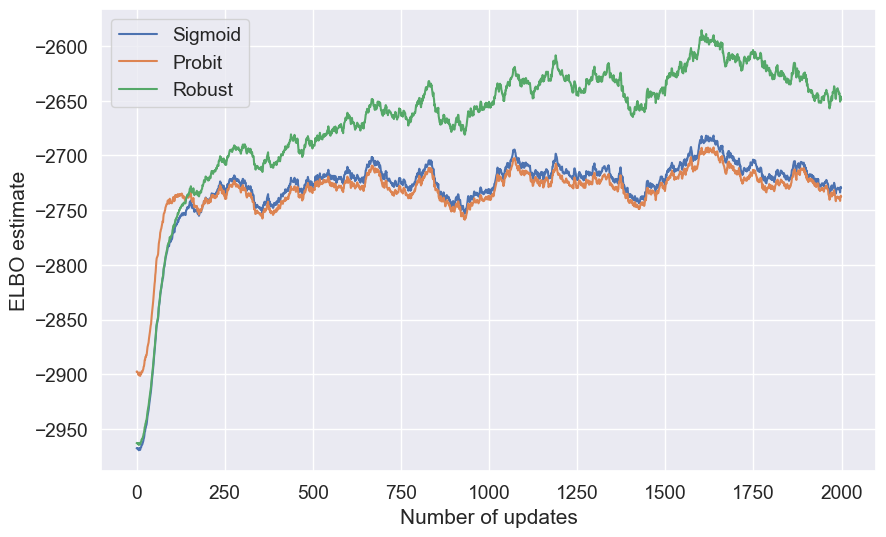

In [ ]:
from scipy.ndimage.filters import uniform_filter1d

# ------------------------------------------------------------------------------
# Plot smoothed ELBO trajectories for all three BBVI models
# ------------------------------------------------------------------------------
# This plot compares the Evidence Lower Bound (ELBO) optimization trajectories
# for three different Bayesian binary classification models:
#   - Sigmoid (logistic regression)
#   - Probit (probit regression)
#   - Robust (robust logistic regression with label noise)
#
# Each model was trained using Black-Box Variational Inference (BBVI).
# The ELBO is a lower bound on the marginal likelihood (evidence) and is
# maximized during variational inference. Smoother ELBO curves indicate
# more stable optimization.
#
# We use a moving average (uniform_filter1d) to smooth the noisy ELBO estimates.
#
# ------------------------------------------------------------------------------
# Mathematical background:
#   - At each iteration t, the BBVI algorithm estimates the ELBO:
#         ELBO_t = E_{q(w)}[ log p(y|X,w) ] + E_{q(w)}[ log p(w) ] + H[q(w)]
#     where:
#         - q(w): variational posterior (mean-field Gaussian)
#         - p(y|X,w): likelihood (varies by model)
#         - p(w): prior (Gaussian)
#         - H[q(w)]: entropy of q(w)
#   - The ELBO is estimated stochastically using Monte Carlo samples.
#   - The optimization trajectory is tracked in bbviX.ELBO_history (shape: [num_updates,])
#
# ------------------------------------------------------------------------------
# Input shapes:
#   - bbvi1.ELBO_history: (num_updates,)  # Sigmoid model ELBOs
#   - bbvi2.ELBO_history: (num_updates,)  # Probit model ELBOs
#   - bbvi3.ELBO_history: (num_updates,)  # Robust model ELBOs
#
# Output:
#   - A matplotlib figure showing the smoothed ELBO curves for all three models.
#     X-axis: Number of updates (iterations)
#     Y-axis: ELBO estimate (smoothed)
#     Each curve corresponds to a different model.
# ------------------------------------------------------------------------------

# Smoothing window size for moving average (in updates)
window_size = 100

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot smoothed ELBO for Sigmoid (logistic regression) model
# uniform_filter1d applies a moving average of window_size to reduce noise
ax.plot(
    uniform_filter1d(bbvi1.ELBO_history, window_size),
    label='Sigmoid (Logistic Regression)'
)

# Plot smoothed ELBO for Probit regression model
ax.plot(
    uniform_filter1d(bbvi2.ELBO_history, window_size),
    label='Probit Regression'
)

# Plot smoothed ELBO for Robust logistic regression model
ax.plot(
    uniform_filter1d(bbvi3.ELBO_history, window_size),
    label='Robust Logistic Regression'
)

# Add legend and axis labels
ax.legend()
ax.set(
    xlabel='Number of updates (iterations)',
    ylabel='ELBO estimate (smoothed)',
    title='BBVI Optimization Trajectories: Smoothed ELBO for Three Models'
)
plt.show()

**End of solution**

In this exercise, we assumed $\epsilon = 0.05$. In practice, one could learn this way by either simply optimizing the ELBO wrt. $\epsilon$ (corresponding to a marginal likelihood estimate). A more Bayesian approach would be to impose a Beta-prior distribution on $\epsilon$ and compute the posterior distribution using BBVI as well. Furthermore, it is possible to get much better performance in this dataset, but the purpose of the exercise is to learn BBVI and see how easy it is to prototype different models.

**Task 6.4**: Suppose we decided to augment the model with a prior distribution for $\epsilon \in \left[0, 1\right]$, e.g. $p(\epsilon) = \text{Beta}(\epsilon|a,b)$. How would you adapt the variational family?

**Hints**: What is the support a mean-field Gaussian distribution?


**Solution**

Gaussian distributions have support on the entire real line, but $\epsilon \in \left[0, 1\right]$ is a probability and therefore a number in the unit interval. Naively augmenting the variational family to $q(\mathbf{w}, \epsilon) = \left[\prod_{i=1}^D \mathcal{N}(w_i|m_i, v_i)\right] \mathcal{N}(\epsilon|\mu, \tau)$ would  therefore be a bad idea. Instead, we could consider one of the two solutions: 1) either make a change of variable to make the support of the distributions compatible, e.g. $\tilde{\epsilon} = \sigma^{-1}(\epsilon) \in \mathbb{R}$ (where $\sigma(\cdot)$ is the logistic sigmoid function) and impose a mean-field Gaussian over $\tilde{\epsilon}$, which is now a real number or 2) Use a variational family of the form $q(\mathbf{w}, \epsilon) = \left[\prod_{i=1}^D \mathcal{N}(w_i|m_i, v_i)\right] \text{Beta}(\epsilon|\tilde{a}, \tilde{b})$. The drawback of the latter is that we have to adapt our code accordingly.

**End of solution**